In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
#%matplotlib inline
%matplotlib notebook
import scipy.signal
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
from scipy.stats import binned_statistic
from scipy.signal import resample
from scipy.signal import argrelextrema

import AdvancedBraggEdgeFitting
import TOF_routines
from TOF_routines import binning
from TOF_routines import tof2l
from TOF_routines import l2tof
from TOF_routines import find_nearest

In [2]:
# here now I put the number obtained from the flight-path calibration
t0 =  0.0002466
L = 56.065
lambda0 = 0.017
dL = 0

In [3]:
# Load of computed spectra for the selected ROIs
ref_304 = np.loadtxt('spectrum_ref_304.txt')
ob_304 = np.loadtxt('spectrum_ob_ref_304.txt')
ref_316 = np.loadtxt('spectrum_ref_316.txt')
ob_316 = np.loadtxt('spectrum_ob_ref_316.txt')


# Load TOF
myTOF = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/03_VerticalSetting_3hruns/Flat1_Corrected/IMAT00010433_VerticalSetting_2hruns_000_Spectra.txt', usecols=0)

In [4]:
# Load some theoretical values
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)
mygamma = np.genfromtxt('gamma.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)

dhkl_gammaFe = np.genfromtxt('gammaFe_hkl', usecols=4)
h_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=0)
k_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=1)
l_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=2)

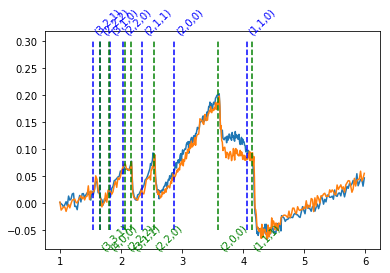

In [5]:
# Angle by angle comparison, now normalization by the last part
ref304_spectrum_norm=(ref_304[0][:]/ob_304[0][:])
last_part_304 = np.mean(ref304_spectrum_norm[1500:2000]) 
ref304_spectrum_norm = ref304_spectrum_norm/last_part_304
ref304_spectrum_binned = TOF_routines.binning(ref304_spectrum_norm, 350)
ref316_spectrum_norm=(ref_316[0][:]/ob_316[0][:])
last_part_316 = np.mean(ref316_spectrum_norm[1500:2000])      
ref316_spectrum_norm= ref316_spectrum_norm/last_part_316
ref316_spectrum_binned = TOF_routines.binning(ref316_spectrum_norm, 350)
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(ref304_spectrum_binned))
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(ref316_spectrum_binned))

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([-0.05,0.3]), '--b',label=r'$\alpha$ Fe - Martensite')
    else:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([-0.05,0.3]), '--b')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],0.35, mytext, rotation=45, color='b')

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([-0.05,0.3]), '--g', label=r'$\gamma$ Fe - Austenite')
    else:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([-0.05,0.3]), '--g')                    

    mytext = '('+str((h_gammaFe[i]).astype(int))+','+str(k_gammaFe[i].astype(int))+','+str(l_gammaFe[i].astype(int))+')'
    plt.text(2*dhkl_gammaFe[i],-0.05, mytext, rotation=45, color='g')

In [7]:
# Here I create the spectra only once, since I then use parts of them for the peak fitting
ref304_spectrum_binned =[]
ref316_spectrum_binned =[]

for i in range(0, len(ref_304)):
    ref304_spectrum_norm=(ref_304[i][:]/ob_304[i][:]) # This is now already computed at the beginnig
    last_part_304 =  np.mean(ref304_spectrum_norm[1500:2000]) 
    ref304_spectrum_norm = ref304_spectrum_norm/last_part_304
    ref304_spectrum_binned.append(binning(ref304_spectrum_norm, 350))
    ref316_spectrum_norm=(ref_316[i][:]/ob_316[i][:])
    last_part_316 = np.mean(ref316_spectrum_norm[1500:2000])
    ref316_spectrum_norm = ref316_spectrum_norm/last_part_316
    ref316_spectrum_binned.append(binning(ref316_spectrum_norm, 350))

Text(0.5, 1.0, '(1,1,1)')

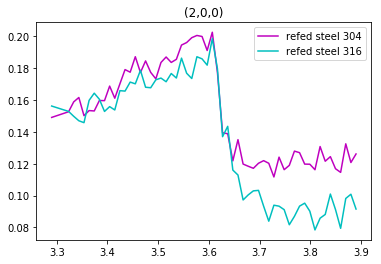

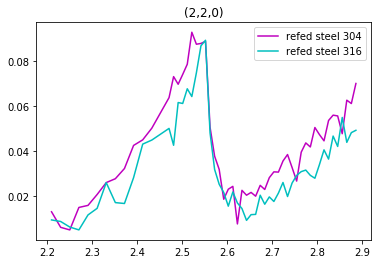

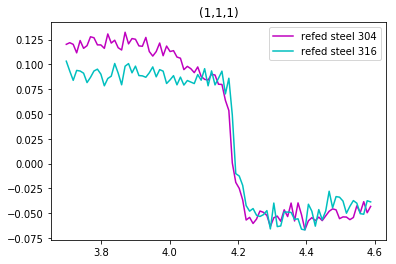

In [24]:
# Here I define the peak position and the range for the three studied edges

mylambda_binned = binning(tof2l(myTOF, lambda0,t0,L),350)
# peak_position_200 = find_nearest(mylambda_binned, 3.588)
peak_position_200 = find_nearest(mylambda_binned, 3.62) # trying to change this for the ref sample. It worked
lambda_range_200 = [3.3, 3.9]
myrange_200 = np.array([find_nearest(mylambda_binned, lambda_range_200[0]), find_nearest(mylambda_binned, lambda_range_200[1])])

plt.figure()
plt.plot(mylambda_binned[myrange_200[0]:myrange_200[1]], -1*np.log(ref304_spectrum_binned[0][myrange_200[0]:myrange_200[1]]), label='refed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_200[0]:myrange_200[1]], -1*np.log(ref316_spectrum_binned[0][myrange_200[0]:myrange_200[1]]), label='refed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(2,0,0)')


peak_position_220 = find_nearest(mylambda_binned, 2.536)
lambda_range1 = find_nearest(mylambda_binned, 2.2)
lambda_range2 = find_nearest(mylambda_binned, 2.9)
myrange_220 = [lambda_range1, lambda_range2]

plt.figure()
plt.plot(mylambda_binned[myrange_220[0]:myrange_220[1]], -1*np.log(ref304_spectrum_binned[0][myrange_220[0]:myrange_220[1]]), label='refed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_220[0]:myrange_220[1]], -1*np.log(ref316_spectrum_binned[0][myrange_220[0]:myrange_220[1]]), label='refed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(2,2,0)')

peak_position_111 = find_nearest(mylambda_binned, 4.2)
lambda_range1 = find_nearest(mylambda_binned, 3.7)
lambda_range2 = find_nearest(mylambda_binned, 4.6)
myrange_111 = [lambda_range1, lambda_range2]

plt.figure()
plt.plot(mylambda_binned[myrange_111[0]:myrange_111[1]], -1*np.log(ref304_spectrum_binned[0][myrange_111[0]:myrange_111[1]]), label='refed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_111[0]:myrange_111[1]], -1*np.log(ref316_spectrum_binned[0][myrange_111[0]:myrange_111[1]]), label='refed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(1,1,1)')

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 64
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00177702
    reduced chi-square = 3.4843e-05
    Akaike info crit   = -588.809230
    Bayesian info crit = -574.386129
[[Variables]]
    t0:     30.4290123 +/- 0.21828137 (0.72%) (init = 34.81784)
    sigma: -1.04580927 +/- 0.31122017 (29.76%) (init = -0.7256453)
    alpha: -0.35167798 +/- 1.37819949 (391.89%) (init = -11.32841)
    a1:     0.12120131 +/- 0.01008165 (8.32%) (init = 0.1025437)
    a2:     9.3666e-04 +/- 1.0824e-04 (11.56%) (init = 0.002186007)
    a5:    -9.1226e-04 +/- 2.5953e-04 (28.45%) (init = -0.001536565)
    a6:    -14.9650417 +/- 5.89713919 (39.41%) (init = -9.716976)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.983
    C(a1, a5)       = -0.956
    C(a1, a6)       =  0.925
    C(a1, a2)       = -0.746
    C(sigma, 

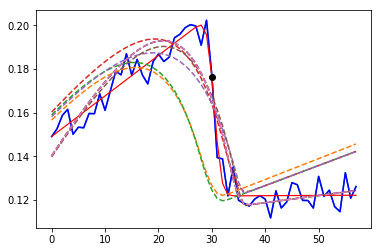

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 36
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00264746
    reduced chi-square = 5.1911e-05
    Akaike info crit   = -565.686665
    Bayesian info crit = -551.263564
[[Variables]]
    t0:     31.6493129 +/- 0.24848201 (0.79%) (init = 35.90636)
    sigma: -1.81365309 +/- 0.31789363 (17.53%) (init = -0.4965043)
    alpha: -0.25505976 +/- 4087351.53 (1602507371.56%) (init = -11.7543)
    a1:     0.11228388 +/- 0.01473718 (13.12%) (init = 0.1073738)
    a2:     5.4281e-04 +/- 1.5070e-04 (27.76%) (init = 0.00166129)
    a5:    -0.00109504 +/- 3.6626e-04 (33.45%) (init = -0.002217111)
    a6:    -26.5382676 +/- 11.3730896 (42.86%) (init = -9.137166)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.984
    C(a1, a5)    = -0.947
    C(a1, a6)    =  0.896
    C(a1, a2)    = -0.865
    C(a2, a5)    = 

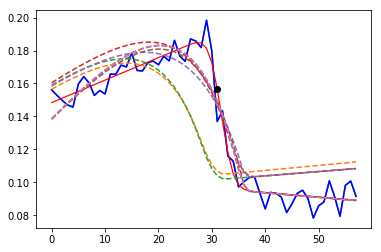

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 52
    # variables        = 7
    chi-square         = 3.8274e-04
    reduced chi-square = 8.5053e-06
    Akaike info crit   = -600.608944
    Bayesian info crit = -586.950238
[[Variables]]
    t0:     20.1681644 (init = 24.79698)
    sigma: -2.00481914 (init = -1.069014)
    alpha: -0.21198067 (init = -15.04335)
    a1:    -0.04055093 (init = -0.05472011)
    a2:     0.00354192 (init = 0.006405061)
    a5:    -1.4533e-04 (init = -0.002282568)
    a6:    -7.66141297 (init = -5.632378)



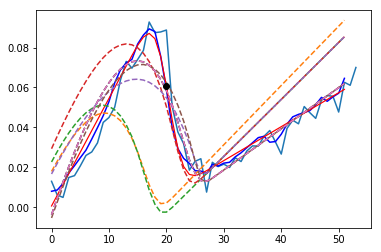

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 52
    # variables        = 7
    chi-square         = 8.3481e-04
    reduced chi-square = 1.8551e-05
    Akaike info crit   = -560.056917
    Bayesian info crit = -546.398211
[[Variables]]
    t0:     20.6766299 (init = 25.58751)
    sigma: -1.70705696 (init = -1.326181)
    alpha: -0.21012627 (init = -15.69412)
    a1:    -0.03376322 (init = -0.04985646)
    a2:     0.00292563 (init = 0.005438729)
    a5:    -1.9219e-04 (init = -0.001958655)
    a6:    -7.18255850 (init = -5.683489)



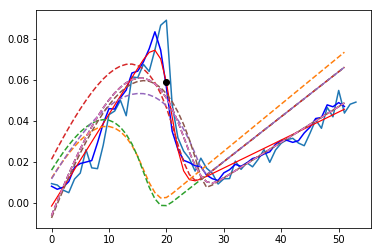

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00223710
    reduced chi-square = 2.7964e-05
    Akaike info crit   = -905.457837
    Bayesian info crit = -888.196480
[[Variables]]
    t0:     49.3077653 +/- 0.34660487 (0.70%) (init = 48.89609)
    sigma: -0.98820149 +/- 0.28903691 (29.25%) (init = -0.9446672)
    alpha: -3.44098286 +/- 0.46422339 (13.49%) (init = -2.894228)
    a1:    -0.02200249 +/- 0.01385456 (62.97%) (init = -0.0559182)
    a2:    -2.0789e-04 +/- 6.3366e-05 (30.48%) (init = -0.0003630113)
    a5:     5.2522e-04 +/- 1.4015e-04 (26.68%) (init = 0.000314437)
    a6:     258.967963 +/- 38.7432450 (14.96%) (init = 262.485)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.900
    C(a1, a2)       =  0.892
    C(a5, a6)       = -0.833
    C(a1, a5)       =  0.762
    C(t0, sig

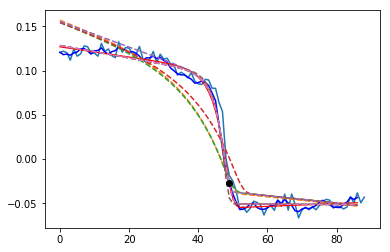

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 53
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00180698
    reduced chi-square = 2.2587e-05
    Akaike info crit   = -924.034683
    Bayesian info crit = -906.773326
[[Variables]]
    t0:     48.1023216 (init = 47.86625)
    sigma: -2.13101468 (init = -2.010044)
    alpha: -0.25778183 (init = -0.4740989)
    a1:     0.05222776 (init = 0.06703376)
    a2:     1.4293e-04 (init = 7.455701e-05)
    a5:     6.7890e-04 (init = 0.0002903674)
    a6:     315.120351 (init = 697.7556)

0.0


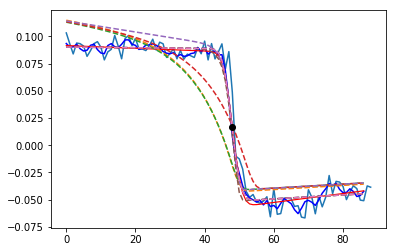

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 61
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00169287
    reduced chi-square = 3.3194e-05
    Akaike info crit   = -591.622721
    Bayesian info crit = -577.199620
[[Variables]]
    t0:     30.5325115 +/- 0.18552396 (0.61%) (init = 35.00137)
    sigma: -1.39170706 +/- 0.28187886 (20.25%) (init = -1.192175)
    alpha: -0.34584999 +/- 14.7485908 (4264.45%) (init = -11.61153)
    a1:     0.08355144 +/- 0.01531092 (18.33%) (init = 0.06745781)
    a2:     8.9128e-04 +/- 1.1233e-04 (12.60%) (init = 0.002217962)
    a5:    -5.0184e-04 +/- 2.6661e-04 (53.13%) (init = -0.001235205)
    a6:    -33.1304208 +/- 10.9008179 (32.90%) (init = -15.60409)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.977
    C(a1, a5)       = -0.972
    C(a1, a6)       =  0.916
    C(a1, a2)       = -0.697
    C(sigma

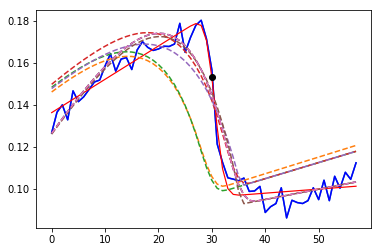

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 515
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00184615
    reduced chi-square = 3.6199e-05
    Akaike info crit   = -586.595443
    Bayesian info crit = -572.172342
[[Variables]]
    t0:     31.5685882 +/- 0.28412944 (0.90%) (init = 35.82261)
    sigma: -1.99552049 +/- 0.40991959 (20.54%) (init = -0.08678183)
    alpha: -0.72909073 +/- 1.24791776 (171.16%) (init = -11.7309)
    a1:     0.01106058 +/- 0.04235409 (382.93%) (init = 0.04717078)
    a2:     0.00117983 +/- 1.2969e-04 (10.99%) (init = 0.002376216)
    a5:     1.8450e-04 +/- 3.2547e-04 (176.41%) (init = -0.001036131)
    a6:    -70.0545189 +/- 28.3452004 (40.46%) (init = -18.07574)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.998
    C(a5, a6)       = -0.969
    C(a1, a6)       =  0.962
    C(sigma, alpha) = -0.702
    C(t0

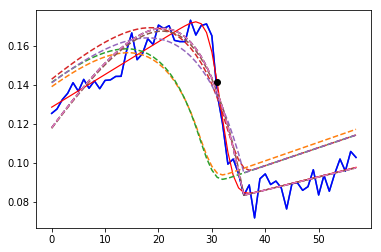

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 52
    # variables        = 7
    chi-square         = 9.0731e-04
    reduced chi-square = 2.0163e-05
    Akaike info crit   = -555.725830
    Bayesian info crit = -542.067124
[[Variables]]
    t0:     19.6933624 (init = 24.77544)
    sigma: -2.21094254 (init = -1.557563)
    alpha: -0.11851473 (init = -15.2752)
    a1:    -0.06007341 (init = -0.0868938)
    a2:     0.00385920 (init = 0.006654273)
    a5:    -4.3195e-04 (init = -0.002202886)
    a6:    -3.78316599 (init = -5.0704)



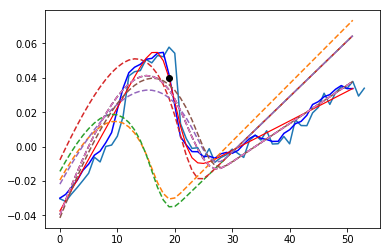

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00104635
    reduced chi-square = 2.3252e-05
    Akaike info crit   = -548.312101
    Bayesian info crit = -534.653395
[[Variables]]
    t0:     20.3694226 (init = 25.39093)
    sigma: -2.09967701 (init = -1.438161)
    alpha: -0.26627687 (init = -15.82654)
    a1:    -0.06014496 (init = -0.08430654)
    a2:     0.00397021 (init = 0.006881865)
    a5:    -4.9128e-04 (init = -0.002460205)
    a6:    -2.24436239 (init = -3.490781)



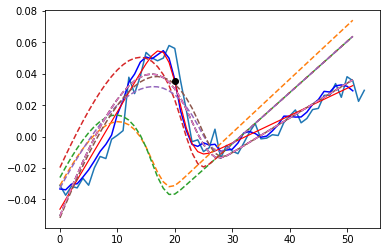

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 126
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00240017
    reduced chi-square = 3.0002e-05
    Akaike info crit   = -899.336752
    Bayesian info crit = -882.075395
[[Variables]]
    t0:     48.8981890 +/- 0.35359343 (0.72%) (init = 49.60308)
    sigma: -1.09246313 +/- 0.23873676 (21.85%) (init = -0.9622904)
    alpha: -2.79241673 +/- 0.39817034 (14.26%) (init = -4.361596)
    a1:    -0.18014038 +/- 0.04889772 (27.14%) (init = -0.1284234)
    a2:     6.8147e-04 +/- 6.2593e-05 (9.19%) (init = 0.0009310922)
    a5:     2.7587e-05 +/- 1.4289e-04 (517.96%) (init = -0.0002779058)
    a6:    -267.426998 +/- 60.9142175 (22.78%) (init = -137.957)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.999
    C(t0, alpha)    = -0.944
    C(a5, a6)       = -0.931
    C(a1, a6)       =  0.919
    C(t0, 

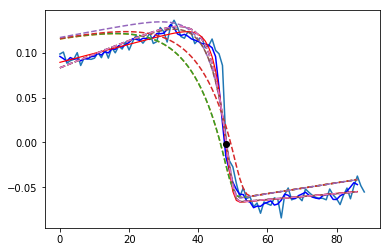

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00356516
    reduced chi-square = 4.4565e-05
    Akaike info crit   = -864.913436
    Bayesian info crit = -847.652079
[[Variables]]
    t0:     49.7935910 +/- 0.52824680 (1.06%) (init = 50.26889)
    sigma: -1.18758817 +/- 0.35029719 (29.50%) (init = -1.167218)
    alpha: -3.00879215 +/- 0.57255962 (19.03%) (init = -3.86662)
    a1:     174.257626 +/- 48204.3428 (27662.69%) (init = 229.7765)
    a2:     3.9918e-04 +/- 7.8534e-05 (19.67%) (init = 0.0005263742)
    a5:     3.9957e-04 +/- 1.3674e-04 (34.22%) (init = 0.0005267837)
    a6:     436525.434 +/- 1.2076e+08 (27664.30%) (init = 436525.4)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(t0, alpha)    = -0.946
    C(t0, sigma)    =  0.831
    C(a5, a6)       = -0.819
    C(a1,

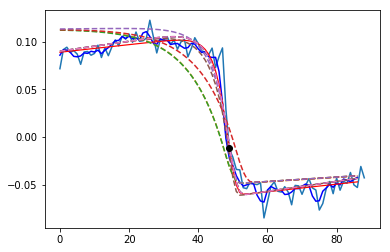

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 80
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00232542
    reduced chi-square = 4.5597e-05
    Akaike info crit   = -573.209167
    Bayesian info crit = -558.786066
[[Variables]]
    t0:     30.6239059 (init = 35.10555)
    sigma: -1.96691936 (init = -0.9779825)
    alpha: -0.12196417 (init = -11.36518)
    a1:    -0.05134280 (init = -0.000955949)
    a2:     0.00128716 (init = 0.002715078)
    a5:     4.3117e-04 (init = -0.0006420078)
    a6:    -101.280713 (init = -26.63673)



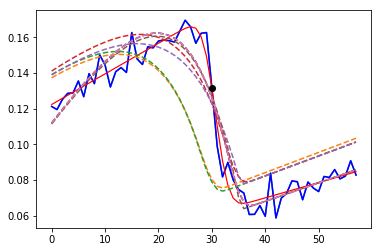

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 73
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00261321
    reduced chi-square = 5.1239e-05
    Akaike info crit   = -566.441812
    Bayesian info crit = -552.018710
[[Variables]]
    t0:     31.7287615 +/- 0.21940653 (0.69%) (init = 35.76618)
    sigma: -1.70184364 +/- 0.30140879 (17.71%) (init = -0.3348388)
    alpha: -0.32443959 +/- 1014.79210 (312783.07%) (init = -10.943)
    a1:    -0.10592132 +/- 0.12797351 (120.82%) (init = 0.008769402)
    a2:     0.00126913 +/- 1.5256e-04 (12.02%) (init = 0.002425403)
    a5:     6.8136e-04 +/- 3.6831e-04 (54.05%) (init = -0.0005291054)
    a6:    -140.841010 +/- 91.0087479 (64.62%) (init = -25.09661)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.991
    C(a1, a6)       =  0.981
    C(a5, a6)       = -0.948
    C(a2, a5)       =  0.577
    C(t

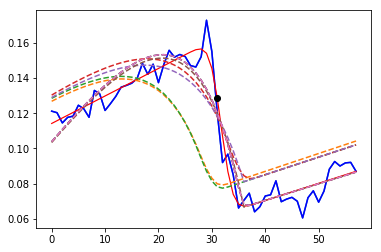

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 52
    # variables        = 7
    chi-square         = 3.0135e-04
    reduced chi-square = 6.6968e-06
    Akaike info crit   = -613.040265
    Bayesian info crit = -599.381559
[[Variables]]
    t0:     19.9796239 +/- 0.13489524 (0.68%) (init = 23.85526)
    sigma: -1.99600973 +/- 0.19380675 (9.71%) (init = -0.9038319)
    alpha: -0.50732825 +/- 9.97517713 (1966.22%) (init = -13.98141)
    a1:    -0.23164402 +/- 0.07645764 (33.01%) (init = -0.08431791)
    a2:     0.00188837 +/- 9.6810e-05 (5.13%) (init = 0.003963513)
    a5:     0.00134621 +/- 1.3415e-04 (9.97%) (init = -0.0004914553)
    a6:    -112.251125 +/- 44.5221027 (39.66%) (init = -16.80927)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.994
    C(a1, a5)       = -0.964
    C(a5, a6)       = -0.929
    C(a2, a6)       =  0.743
    C(a1, 

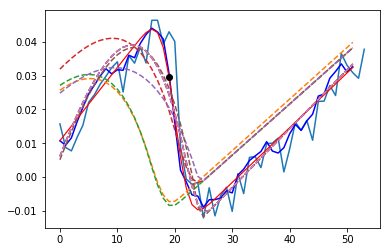

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 52
    # variables        = 7
    chi-square         = 4.8529e-04
    reduced chi-square = 1.0784e-05
    Akaike info crit   = -588.264152
    Bayesian info crit = -574.605445
[[Variables]]
    t0:     21.7062551 +/- 1.22103126 (5.63%) (init = 24.70625)
    sigma: -1.03327669 +/- 0.64743850 (62.66%) (init = -1.000701)
    alpha: -1.71275424 +/- 1.12121473 (65.46%) (init = -14.89381)
    a1:    -0.06510302 +/- 0.00954210 (14.66%) (init = -0.05951788)
    a2:     0.00213482 +/- 1.2373e-04 (5.80%) (init = 0.004280661)
    a5:     3.4663e-04 +/- 1.7130e-04 (49.42%) (init = -0.001403105)
    a6:    -22.4810492 +/- 4.76211495 (21.18%) (init = -9.622849)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.984
    C(a5, a6)       = -0.978
    C(t0, sigma)    =  0.968
    C(a1, a5)       = -0.962
    C(sigma, 

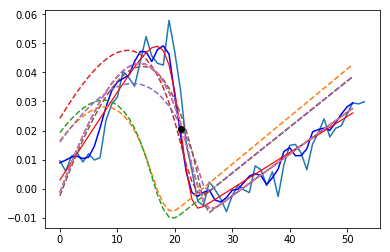

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00358005
    reduced chi-square = 4.4751e-05
    Akaike info crit   = -864.550891
    Bayesian info crit = -847.289534
[[Variables]]
    t0:     47.3073393 (init = 50.23801)
    sigma: -1.95398861 (init = -1.05537)
    alpha: -0.19133931 (init = -4.79523)
    a1:    -0.11426794 (init = -0.1215855)
    a2:     0.00134132 (init = 0.002096001)
    a5:    -7.1711e-04 (init = -0.001208268)
    a6:    -71.4108486 (init = -43.22094)



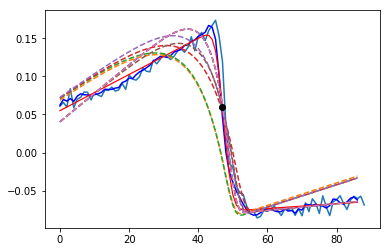

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 37
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00210620
    reduced chi-square = 2.6328e-05
    Akaike info crit   = -910.703652
    Bayesian info crit = -893.442295
[[Variables]]
    t0:     49.0111195 +/- 0.41015963 (0.84%) (init = 50.83133)
    sigma: -1.08946190 +/- 0.24871703 (22.83%) (init = -0.7774164)
    alpha: -2.30345290 +/- 0.40722543 (17.68%) (init = -6.3392)
    a1:    -0.04235430 +/- 0.01028667 (24.29%) (init = -0.05924489)
    a2:     7.5526e-04 +/- 5.6582e-05 (7.49%) (init = 0.001388711)
    a5:    -0.00107330 +/- 1.3354e-04 (12.44%) (init = -0.001483759)
    a6:    -63.6270553 +/- 7.12612613 (11.20%) (init = -39.39262)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.973
    C(t0, alpha)    = -0.965
    C(a1, a5)       = -0.939
    C(t0, sigma)    =  0.903
    C(sigma, a

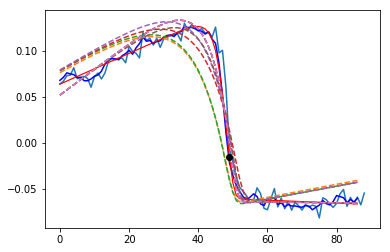

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00267239
    reduced chi-square = 5.2400e-05
    Akaike info crit   = -565.143044
    Bayesian info crit = -550.719942
[[Variables]]
    t0:     31.2474347 +/- 0.20761877 (0.66%) (init = 35.64556)
    sigma: -2.18147703 +/- 0.24875139 (11.40%) (init = -0.8423073)
    alpha: -0.32841844 +/- 597063.149 (181799519.33%) (init = -11.60149)
    a1:    -0.15019404 +/- 0.08792941 (58.54%) (init = -0.03716496)
    a2:     0.00225358 +/- 1.7440e-04 (7.74%) (init = 0.003811627)
    a5:     0.00109286 +/- 3.8740e-04 (35.45%) (init = -0.0005073363)
    a6:    -88.5373936 +/- 35.0331858 (39.57%) (init = -21.72359)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)    = -0.995
    C(a1, a6)    =  0.975
    C(a5, a6)    = -0.951
    C(t0, a6)    = -0.647
    C(t0, a1)   

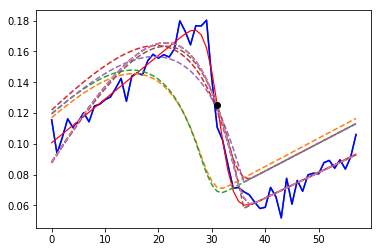

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 48
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00294157
    reduced chi-square = 5.7678e-05
    Akaike info crit   = -559.576853
    Bayesian info crit = -545.153752
[[Variables]]
    t0:     31.2016230 +/- 0.18734125 (0.60%) (init = 35.57242)
    sigma: -1.44409962 +/- 0.25183223 (17.44%) (init = -0.003630425)
    alpha: -0.24396862 +/- 15011.5761 (6153076.55%) (init = -11.24345)
    a1:    -0.06301055 +/- 0.05823262 (92.42%) (init = -0.02365258)
    a2:     0.00167234 +/- 1.5548e-04 (9.30%) (init = 0.003129082)
    a5:     5.7881e-04 +/- 3.6476e-04 (63.02%) (init = -0.0004572388)
    a6:    -71.1552015 +/- 29.4765179 (41.43%) (init = -22.46878)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.998
    C(a1, a6)       =  0.968
    C(a5, a6)       = -0.960
    C(a2, a5)       =  0.540
    

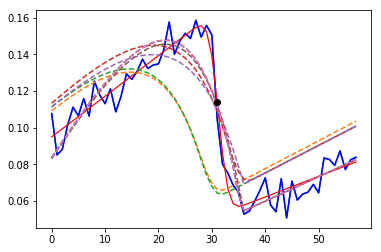

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 38
    # data points      = 52
    # variables        = 7
    chi-square         = 8.5910e-04
    reduced chi-square = 1.9091e-05
    Akaike info crit   = -558.565064
    Bayesian info crit = -544.906358
[[Variables]]
    t0:     20.1511510 (init = 24.87995)
    sigma: -2.45391925 (init = -1.556876)
    alpha: -0.24385447 (init = -15.31156)
    a1:    -0.06825233 (init = -0.05521374)
    a2:     0.00223625 (init = 0.004118074)
    a5:     6.5140e-04 (init = -0.0008983121)
    a6:    -27.2942400 (init = -11.95858)



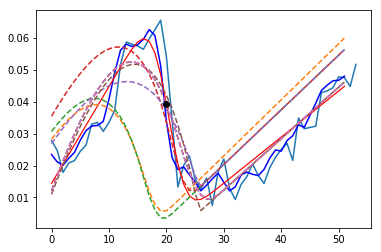

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00101101
    reduced chi-square = 2.2467e-05
    Akaike info crit   = -550.098429
    Bayesian info crit = -536.439723
[[Variables]]
    t0:     20.2231037 (init = 25.02069)
    sigma: -2.12727160 (init = -1.317736)
    alpha: -0.13109853 (init = -15.40233)
    a1:    -0.04303084 (init = -0.05370696)
    a2:     0.00260038 (init = 0.004797487)
    a5:    -1.2588e-04 (init = -0.001755288)
    a6:    -9.39021240 (init = -6.633959)



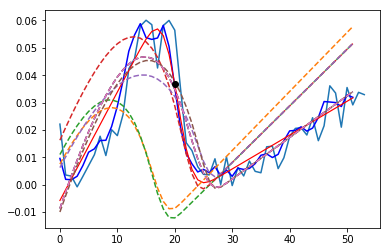

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00604245
    reduced chi-square = 7.5531e-05
    Akaike info crit   = -819.012235
    Bayesian info crit = -801.750878
[[Variables]]
    t0:     47.3299335 (init = 49.95301)
    sigma: -1.67687464 (init = -0.8795646)
    alpha: -0.08331994 (init = -4.304967)
    a1:    -0.09421723 (init = -0.110228)
    a2:     0.00158389 (init = 0.002476445)
    a5:    -0.00129470 (init = -0.001851559)
    a6:    -46.8221776 (init = -30.33915)



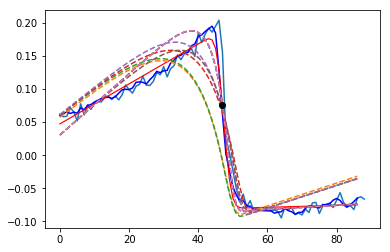

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00653246
    reduced chi-square = 8.1656e-05
    Akaike info crit   = -812.228501
    Bayesian info crit = -794.967144
[[Variables]]
    t0:     48.1426426 +/- 0.10836188 (0.23%) (init = 50.13673)
    sigma: -1.74912623 +/- 0.14659972 (8.38%) (init = -0.9912829)
    alpha: -0.27282276 +/- 88416.7560 (32408130.19%) (init = -3.254364)
    a1:    -0.12058632 +/- 0.02451126 (20.33%) (init = -0.1108081)
    a2:     0.00141797 +/- 9.7440e-05 (6.87%) (init = 0.002036774)
    a5:    -6.9291e-04 +/- 2.3642e-04 (34.12%) (init = -0.001312517)
    a6:    -67.1656328 +/- 11.0458054 (16.45%) (init = -38.3922)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.981
    C(a5, a6)       = -0.974
    C(a1, a6)       =  0.923
    C(a1, a2)       = -0.739
    C(a2,

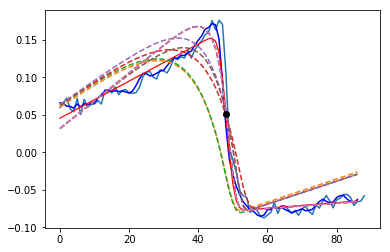

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 38
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00211423
    reduced chi-square = 4.1455e-05
    Akaike info crit   = -578.731545
    Bayesian info crit = -564.308444
[[Variables]]
    t0:     31.0984386 (init = 35.23352)
    sigma: -1.55062674 (init = -0.6459896)
    alpha: -0.16376128 (init = -10.40205)
    a1:    -0.18640451 (init = -0.03574717)
    a2:     0.00213934 (init = 0.003750558)
    a5:     0.00124749 (init = -8.587288e-05)
    a6:    -123.822274 (init = -28.26285)



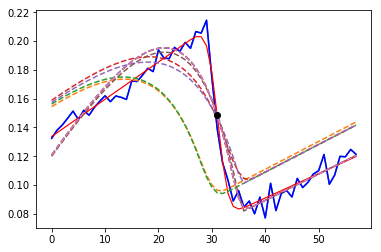

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 47
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00274990
    reduced chi-square = 5.3920e-05
    Akaike info crit   = -563.484695
    Bayesian info crit = -549.061594
[[Variables]]
    t0:     31.6412054 (init = 36.18095)
    sigma: -1.91289101 (init = -0.7803496)
    alpha: -0.16839082 (init = -11.89327)
    a1:    -0.05957363 (init = -0.003328881)
    a2:     0.00196537 (init = 0.003475175)
    a5:     5.9332e-04 (init = -0.0008796915)
    a6:    -63.3274298 (init = -18.16372)



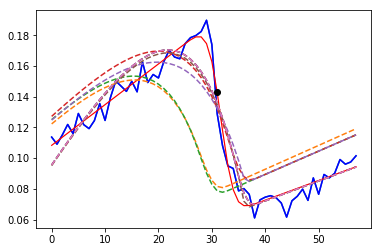

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 52
    # variables        = 7
    chi-square         = 2.8458e-04
    reduced chi-square = 6.3241e-06
    Akaike info crit   = -616.017705
    Bayesian info crit = -602.358999
[[Variables]]
    t0:     19.8031961 (init = 24.44652)
    sigma: -1.99698981 (init = -1.222751)
    alpha: -0.14616170 (init = -14.75098)
    a1:    -0.04728120 (init = -0.06020514)
    a2:     0.00294531 (init = 0.005381517)
    a5:     4.1966e-05 (init = -0.001698233)
    a6:    -10.5037719 (init = -7.449201)



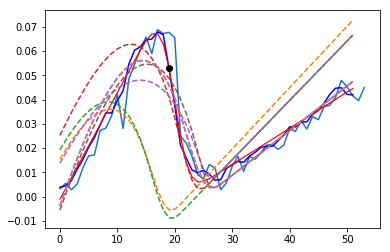

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 52
    # variables        = 7
    chi-square         = 5.3538e-04
    reduced chi-square = 1.1897e-05
    Akaike info crit   = -583.156706
    Bayesian info crit = -569.498000
[[Variables]]
    t0:     20.3370205 (init = 24.77943)
    sigma: -2.16151464 (init = -0.6714979)
    alpha: -0.19373351 (init = -15.02797)
    a1:    -0.05617089 (init = -0.06291241)
    a2:     0.00300463 (init = 0.005705639)
    a5:    -3.1763e-04 (init = -0.002528672)
    a6:    -9.34743637 (init = -5.52498)



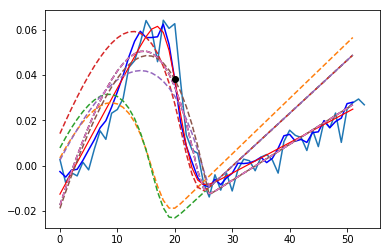

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 48
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00302835
    reduced chi-square = 3.7854e-05
    Akaike info crit   = -879.111125
    Bayesian info crit = -861.849768
[[Variables]]
    t0:     48.8108282 +/- 0.35183099 (0.72%) (init = 50.17463)
    sigma: -1.17256894 +/- 0.22111980 (18.86%) (init = -0.979006)
    alpha: -2.68114398 +/- 0.37253518 (13.89%) (init = -5.586616)
    a1:    -0.14501422 +/- 0.02160495 (14.90%) (init = -0.1462796)
    a2:     0.00130574 +/- 7.0158e-05 (5.37%) (init = 0.001940179)
    a5:    -5.0772e-04 +/- 1.6103e-04 (31.72%) (init = -0.0009064893)
    a6:    -103.685913 +/- 11.8436272 (11.42%) (init = -64.97601)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.980
    C(a5, a6)       = -0.958
    C(t0, alpha)    = -0.957
    C(a1, a6)       =  0.890
    C(t0, sig

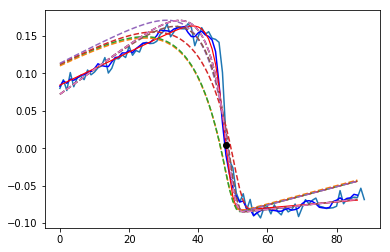

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00542837
    reduced chi-square = 6.7855e-05
    Akaike info crit   = -828.336113
    Bayesian info crit = -811.074756
[[Variables]]
    t0:     47.8533433 +/- 0.09223350 (0.19%) (init = 50.90033)
    sigma: -1.70713856 +/- 0.12278434 (7.19%) (init = -0.9811007)
    alpha: -0.24951982 +/- 605786.026 (242780722.74%) (init = -5.036579)
    a1:    -0.09472396 +/- 0.01901283 (20.07%) (init = -0.1186889)
    a2:     0.00130390 +/- 8.8976e-05 (6.82%) (init = 0.002194701)
    a5:    -0.00104140 +/- 2.1229e-04 (20.39%) (init = -0.001475787)
    a6:    -62.1435774 +/- 8.58868542 (13.82%) (init = -39.98665)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.974
    C(a1, a5)    = -0.968
    C(a1, a6)    =  0.901
    C(a1, a2)    = -0.758
    C(a2, a5)    = 

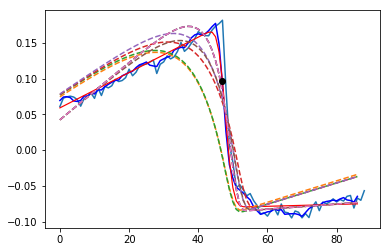

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00176857
    reduced chi-square = 3.4678e-05
    Akaike info crit   = -589.085604
    Bayesian info crit = -574.662503
[[Variables]]
    t0:     30.7221971 +/- 0.24703223 (0.80%) (init = 35.03379)
    sigma: -2.16990337 +/- 0.37582756 (17.32%) (init = -0.9747833)
    alpha: -0.69097645 +/- 2.42674448 (351.21%) (init = -11.07153)
    a1:    -0.00724130 +/- 0.09513217 (1313.74%) (init = 0.06366134)
    a2:     9.2296e-04 +/- 1.2907e-04 (13.98%) (init = 0.002178062)
    a5:     3.7217e-04 +/- 3.1062e-04 (83.46%) (init = -0.0006171015)
    a6:    -157.504976 +/- 92.1238303 (58.49%) (init = -31.42363)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.995
    C(a1, a6)       =  0.969
    C(a5, a6)       = -0.943
    C(sigma, alpha) = -0.667
    C(a

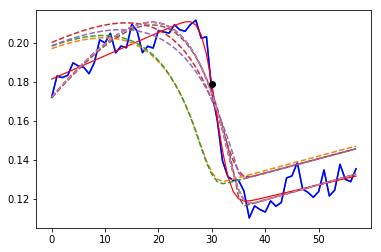

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 44
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00322916
    reduced chi-square = 6.3317e-05
    Akaike info crit   = -554.166621
    Bayesian info crit = -539.743520
[[Variables]]
    t0:     31.1792289 (init = 35.58161)
    sigma: -0.94817103 (init = -0.7781054)
    alpha: -0.12816049 (init = -10.34604)
    a1:     0.02168262 (init = 0.02793736)
    a2:     0.00162394 (init = 0.003095007)
    a5:     1.8555e-04 (init = -0.0006867197)
    a6:    -52.6753429 (init = -21.78922)



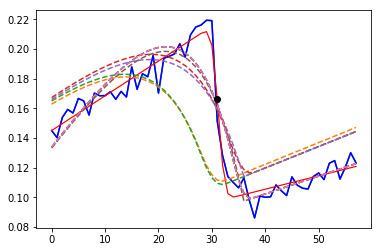

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 52
    # variables        = 7
    chi-square         = 9.9764e-04
    reduced chi-square = 2.2170e-05
    Akaike info crit   = -550.790897
    Bayesian info crit = -537.132191
[[Variables]]
    t0:     19.8151736 +/- 0.23079822 (1.16%) (init = 24.49782)
    sigma: -1.89744820 +/- 0.29498957 (15.55%) (init = -1.15095)
    alpha: -0.76422329 +/- 0.76054657 (99.52%) (init = -14.66445)
    a1:    -0.05198169 +/- 0.00671495 (12.92%) (init = -0.07955492)
    a2:     0.00454683 +/- 1.6036e-04 (3.53%) (init = 0.007775187)
    a5:    -5.2685e-04 +/- 2.3343e-04 (44.31%) (init = -0.002681633)
    a6:    -2.73663899 +/- 1.12655327 (41.17%) (init = -3.931702)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.951
    C(a1, a6)       =  0.925
    C(a1, a5)       = -0.844
    C(t0, alpha)    = -0.738
    C(sigma, a

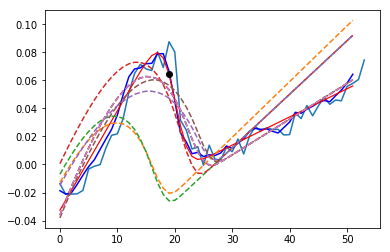

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00119892
    reduced chi-square = 2.6643e-05
    Akaike info crit   = -541.233980
    Bayesian info crit = -527.575274
[[Variables]]
    t0:     21.5226068 +/- 0.92986793 (4.32%) (init = 24.82527)
    sigma: -0.98715773 +/- 0.49416038 (50.06%) (init = -1.180194)
    alpha: -1.88082791 +/- 0.95779614 (50.92%) (init = -15.11252)
    a1:    -0.06762684 +/- 0.00705009 (10.42%) (init = -0.09862931)
    a2:     0.00475831 +/- 2.0262e-04 (4.26%) (init = 0.008556403)
    a5:    -8.6535e-04 +/- 2.7250e-04 (31.49%) (init = -0.003407978)
    a6:    -3.74522940 +/- 1.17227536 (31.30%) (init = -4.417179)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.979
    C(t0, sigma)    =  0.955
    C(a5, a6)       = -0.951
    C(sigma, alpha) = -0.920
    C(a1, a6)

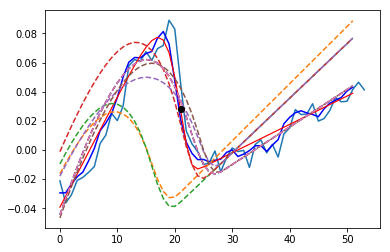

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 139
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00321486
    reduced chi-square = 4.0186e-05
    Akaike info crit   = -873.911529
    Bayesian info crit = -856.650172
[[Variables]]
    t0:     50.0019805 +/- 0.26411842 (0.53%) (init = 49.23402)
    sigma: -0.71120308 +/- 0.36481303 (51.30%) (init = -0.7411638)
    alpha: -6.24532252 +/- 0.59913215 (9.59%) (init = -3.93928)
    a1:     0.81988109 +/- 1.43390662 (174.89%) (init = 0.02246129)
    a2:     4.4638e-04 +/- 9.8627e-05 (22.09%) (init = -1.177697e-05)
    a5:     5.6452e-04 +/- 1.8074e-04 (32.02%) (init = 0.0007165575)
    a6:     1800.73821 +/- 3011.74443 (167.25%) (init = 287.6499)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.994
    C(a5, a6)       = -0.864
    C(a1, a5)       = -0.805
    C(alpha, a1)    = -0.780
    C(t0, 

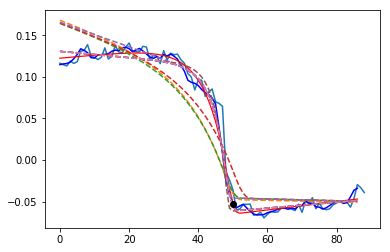

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00300841
    reduced chi-square = 3.7605e-05
    Akaike info crit   = -879.685813
    Bayesian info crit = -862.424457
[[Variables]]
    t0:     49.3524762 +/- 0.28076390 (0.57%) (init = 50.64099)
    sigma: -1.03389345 +/- 0.19976986 (19.32%) (init = -0.9154595)
    alpha: -2.90866642 +/- 0.33280893 (11.44%) (init = -5.938065)
    a1:    -0.08161308 +/- 0.01714166 (21.00%) (init = -0.09644161)
    a2:     9.2951e-04 +/- 7.0136e-05 (7.55%) (init = 0.001564313)
    a5:    -8.9382e-04 +/- 1.6177e-04 (18.10%) (init = -0.001303519)
    a6:    -96.8801891 +/- 11.2651071 (11.63%) (init = -60.39731)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.961
    C(a1, a5)       = -0.953
    C(t0, alpha)    = -0.934
    C(a1, a6)       =  0.840
    C(t0, si

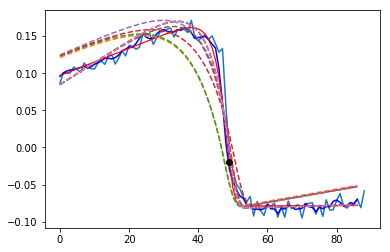

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 48
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00281314
    reduced chi-square = 5.5160e-05
    Akaike info crit   = -562.166008
    Bayesian info crit = -547.742907
[[Variables]]
    t0:     32.1340675 +/- 1.03294481 (3.21%) (init = 34.75532)
    sigma: -0.86237421 +/- 0.78831897 (91.41%) (init = -1.141846)
    alpha: -3.10846973 +/- 1.56290335 (50.28%) (init = -12.31174)
    a1:     0.22874162 +/- 0.00413039 (1.81%) (init = 0.2144369)
    a2:    -5.2929e-04 +/- 1.8151e-04 (34.29%) (init = 0.0004855986)
    a5:    -0.00292939 +/- 3.6891e-04 (12.59%) (init = -0.003298149)
    a6:    -2.83306084 +/- 4.87602196 (172.11%) (init = -4.841572)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.977
    C(a1, a2)       = -0.927
    C(t0, alpha)    = -0.911
    C(t0, sigma)    =  0.775
    C(sigma, 

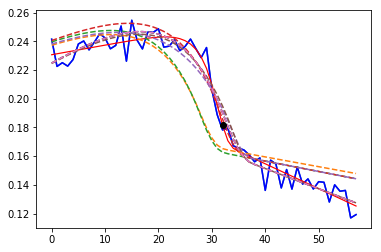

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 108
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00183441
    reduced chi-square = 3.5969e-05
    Akaike info crit   = -586.965692
    Bayesian info crit = -572.542591
[[Variables]]
    t0:     30.8658703 +/- 0.20020281 (0.65%) (init = 35.00039)
    sigma: -1.50624369 +/- 0.28800999 (19.12%) (init = -0.4101454)
    alpha: -0.51233678 +/- 1.24394445 (242.80%) (init = -11.30288)
    a1:     0.15215494 +/- 0.01072788 (7.05%) (init = 0.1369492)
    a2:     0.00101611 +/- 1.1839e-04 (11.65%) (init = 0.002571587)
    a5:    -0.00138705 +/- 2.8872e-04 (20.82%) (init = -0.002482805)
    a6:    -16.9343756 +/- 5.25899676 (31.06%) (init = -8.339791)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.986
    C(a1, a5)       = -0.950
    C(a1, a6)       =  0.915
    C(a1, a2)       = -0.777
    C(sigma,

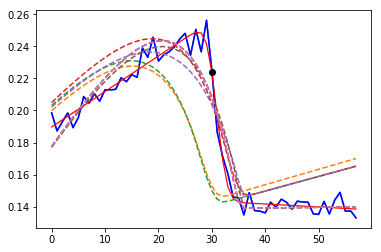

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00231966
    reduced chi-square = 5.1548e-05
    Akaike info crit   = -506.914065
    Bayesian info crit = -493.255359
[[Variables]]
    t0:     20.3623487 (init = 25.45017)
    sigma: -1.98339684 (init = -1.423777)
    alpha: -0.27204333 (init = -15.74168)
    a1:    -0.03644317 (init = -0.07260165)
    a2:     0.00573787 (init = 0.009860463)
    a5:    -7.0011e-04 (init = -0.003428005)
    a6:    -1.98167094 (init = -3.45191)



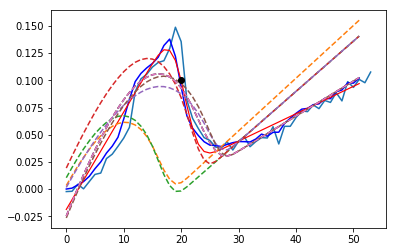

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00217835
    reduced chi-square = 4.8408e-05
    Akaike info crit   = -510.182463
    Bayesian info crit = -496.523757
[[Variables]]
    t0:     20.7338536 (init = 25.48246)
    sigma: -1.85439710 (init = -1.093779)
    alpha: -0.20874839 (init = -15.56622)
    a1:    -0.05276437 (init = -0.07789014)
    a2:     0.00558102 (init = 0.009766982)
    a5:    -4.8089e-04 (init = -0.003578878)
    a6:    -3.37799647 (init = -3.329896)



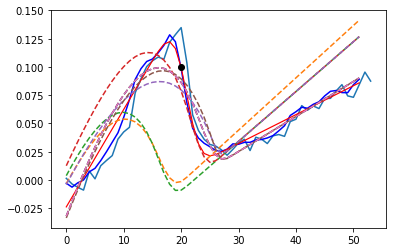

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 39
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00228270
    reduced chi-square = 2.8534e-05
    Akaike info crit   = -903.702475
    Bayesian info crit = -886.441118
[[Variables]]
    t0:     47.1508534 +/- 0.21193232 (0.45%) (init = 46.97506)
    sigma: -2.19733534 +/- 0.32054856 (14.59%) (init = -1.564976)
    alpha: -0.77635860 +/- 0.99980267 (128.78%) (init = -0.1773175)
    a1:    -0.03409496 +/- 0.00190122 (5.58%) (init = -0.03911572)
    a2:    -8.3181e-04 +/- 5.7302e-05 (6.89%) (init = -0.001053453)
    a5:     0.00186344 +/- 1.4129e-04 (7.58%) (init = 0.001517255)
    a6:     89.2648952 +/- 2.06211971 (2.31%) (init = 86.3235)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.915
    C(sigma, alpha) = -0.701
    C(t0, alpha)    = -0.650
    C(a1, a5)       =  0.602
    C(a2, a5)   

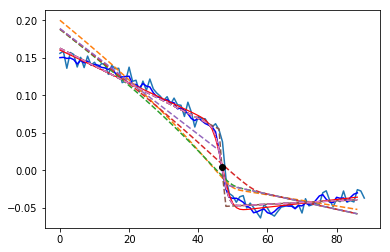

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00285053
    reduced chi-square = 3.5632e-05
    Akaike info crit   = -884.375732
    Bayesian info crit = -867.114375
[[Variables]]
    t0:     47.8700642 (init = 47.70985)
    sigma: -1.99776733 (init = -1.80529)
    alpha: -0.09149736 (init = -0.1222092)
    a1:     0.03401924 (init = 0.009538624)
    a2:     8.0544e-05 (init = -6.577316e-05)
    a5:     0.00124847 (init = 0.0007902475)
    a6:     219.306296 (init = 272.7843)

0.0


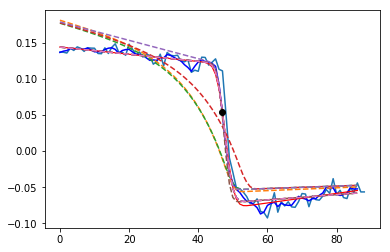

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00185156
    reduced chi-square = 3.6305e-05
    Akaike info crit   = -586.425707
    Bayesian info crit = -572.002606
[[Variables]]
    t0:     34.3909122 +/- 1.25105949 (3.64%) (init = 35.40549)
    sigma: -1.80327243 +/- 0.86056535 (47.72%) (init = -1.454533)
    alpha: -7.85505821 +/- 3.52822104 (44.92%) (init = -13.284)
    a1:     0.17170177 +/- 0.01333851 (7.77%) (init = 0.1710288)
    a2:     9.6536e-04 +/- 3.3079e-04 (34.27%) (init = 0.001425068)
    a5:    -0.00162588 +/- 4.9246e-04 (30.29%) (init = -0.002103856)
    a6:    -14.6509289 +/- 7.45734736 (50.90%) (init = -10.85055)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.988
    C(t0, alpha)    = -0.906
    C(alpha, a2)    = -0.828
    C(t0, sigma)    =  0.772
    C(a1, a6)    

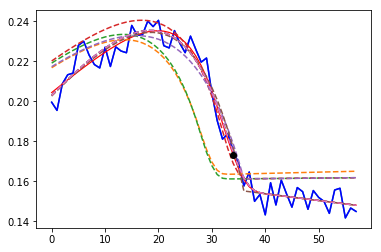

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 251
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00356319
    reduced chi-square = 6.9866e-05
    Akaike info crit   = -548.457440
    Bayesian info crit = -534.034339
[[Variables]]
    t0:     31.6051140 +/- 1.30047754 (4.11%) (init = 35.45318)
    sigma: -0.54050475 +/- 0.72745953 (134.59%) (init = -0.02308129)
    alpha: -0.91411010 +/- 1.06035672 (116.00%) (init = -12.21459)
    a1:     0.16858973 +/- 0.00991490 (5.88%) (init = 0.1355055)
    a2:     4.5302e-04 +/- 1.5498e-04 (34.21%) (init = 0.002220544)
    a5:    -0.00193323 +/- 3.6767e-04 (19.02%) (init = -0.002718831)
    a6:    -14.8899933 +/- 6.46572328 (43.42%) (init = -10.05726)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.985
    C(a5, a6)       = -0.983
    C(t0, sigma)    =  0.965
    C(sigma, alpha) = -0.940
    C(a1, 

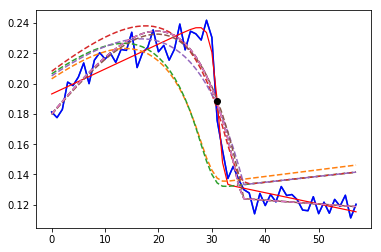

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 52
    # variables        = 7
    chi-square         = 9.1559e-04
    reduced chi-square = 2.0346e-05
    Akaike info crit   = -555.253887
    Bayesian info crit = -541.595181
[[Variables]]
    t0:     20.1735686 (init = 24.75194)
    sigma: -1.71317133 (init = -1.013492)
    alpha: -0.15087200 (init = -14.76235)
    a1:    -0.06745078 (init = -0.09425915)
    a2:     0.00516413 (init = 0.009054827)
    a5:    -2.1466e-04 (init = -0.002950093)
    a6:    -4.88011853 (init = -4.615349)



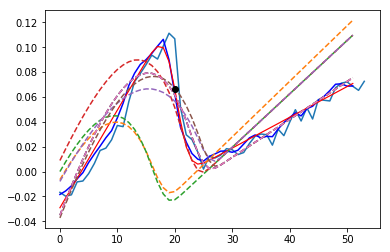

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00125135
    reduced chi-square = 2.7808e-05
    Akaike info crit   = -539.008475
    Bayesian info crit = -525.349769
[[Variables]]
    t0:     20.6606590 (init = 25.35717)
    sigma: -2.11992519 (init = -1.219621)
    alpha: -0.08480074 (init = -15.70439)
    a1:    -0.09899092 (init = -0.1059562)
    a2:     0.00452037 (init = 0.008091561)
    a5:     4.7138e-04 (init = -0.00235157)
    a6:    -11.2310456 (init = -6.585588)



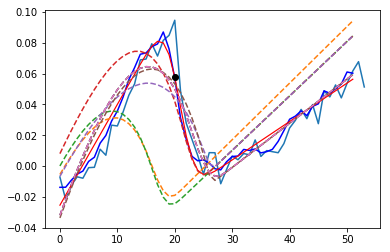

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00324595
    reduced chi-square = 4.0574e-05
    Akaike info crit   = -873.074217
    Bayesian info crit = -855.812860
[[Variables]]
    t0:     49.6644087 +/- 0.29222675 (0.59%) (init = 47.15476)
    sigma: -0.67396300 +/- 0.36943868 (54.82%) (init = -1.617218)
    alpha: -4.52426699 +/- 0.51482008 (11.38%) (init = -1.162046)
    a1:    -0.01182778 +/- 0.00635789 (53.75%) (init = -0.03714561)
    a2:    -3.4570e-04 +/- 8.3594e-05 (24.18%) (init = -0.0008377916)
    a5:     0.00173000 +/- 1.7061e-04 (9.86%) (init = 0.001687502)
    a6:     126.229921 +/- 7.78473099 (6.17%) (init = 99.5611)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.992
    C(t0, alpha)    = -0.796
    C(alpha, a6)    = -0.737
    C(a5, a6)       = -0.712
    C(alpha, a1

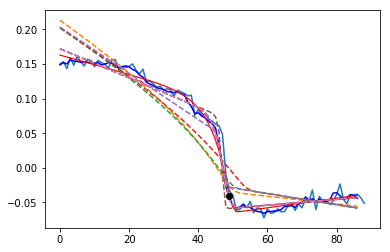

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00202348
    reduced chi-square = 2.5294e-05
    Akaike info crit   = -914.189433
    Bayesian info crit = -896.928076
[[Variables]]
    t0:     47.6726398 +/- 0.10979904 (0.23%) (init = 47.59679)
    sigma: -2.09945030 +/- 0.16637807 (7.92%) (init = -1.975143)
    alpha: -0.65928491 +/- 1.07232477 (162.65%) (init = -0.7115384)
    a1:     0.06938970 +/- 0.01635662 (23.57%) (init = 0.05648136)
    a2:     1.7065e-04 +/- 5.3914e-05 (31.59%) (init = 0.0001010836)
    a5:     8.3175e-04 +/- 1.3470e-04 (16.20%) (init = 0.0006582504)
    a6:     328.931369 +/- 46.5560132 (14.15%) (init = 374.0065)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.886
    C(a1, a2)       =  0.829
    C(sigma, alpha) = -0.682
    C(a2, a5)       =  0.613
    C(t0, a

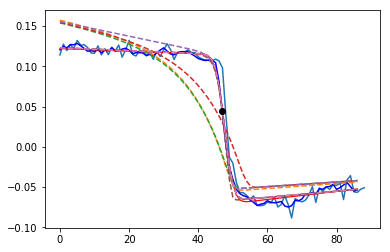

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00199409
    reduced chi-square = 3.9100e-05
    Akaike info crit   = -582.124465
    Bayesian info crit = -567.701364
[[Variables]]
    t0:     32.8349423 +/- 0.73452589 (2.24%) (init = 34.88483)
    sigma: -1.14528863 +/- 0.47677770 (41.63%) (init = -0.8447632)
    alpha: -2.97257495 +/- 0.94430005 (31.77%) (init = -10.69921)
    a1:    -0.30277951 +/- 0.24804979 (81.92%) (init = -0.03824641)
    a2:     0.00213214 +/- 1.6229e-04 (7.61%) (init = 0.003378223)
    a5:     0.00152570 +/- 3.3710e-04 (22.09%) (init = 0.0004223351)
    a6:    -185.893419 +/- 116.191587 (62.50%) (init = -37.86152)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.991
    C(a1, a5)       = -0.964
    C(t0, alpha)    = -0.943
    C(a5, a6)       = -0.919
    C(t0, s

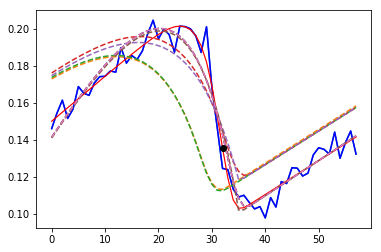

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 44
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00258542
    reduced chi-square = 5.0694e-05
    Akaike info crit   = -567.062049
    Bayesian info crit = -552.638948
[[Variables]]
    t0:     31.3082680 (init = 35.77934)
    sigma: -1.89277447 (init = -0.9124907)
    alpha: -0.17404578 (init = -11.55522)
    a1:     0.04372327 (init = 0.06806814)
    a2:     0.00111580 (init = 0.002603676)
    a5:    -1.6844e-05 (init = -0.001322146)
    a6:    -78.4889066 (init = -21.81757)



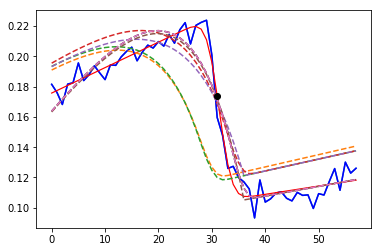

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 52
    # variables        = 7
    chi-square         = 2.2023e-04
    reduced chi-square = 4.8939e-06
    Akaike info crit   = -629.348825
    Bayesian info crit = -615.690119
[[Variables]]
    t0:     19.7053406 +/- 0.31427834 (1.59%) (init = 23.74477)
    sigma: -1.55140516 +/- 0.24830241 (16.01%) (init = -0.943131)
    alpha: -1.19891795 +/- 0.20625445 (17.20%) (init = -13.90281)
    a1:    -0.05826274 +/- 0.00337712 (5.80%) (init = -0.08413319)
    a2:     0.00435301 +/- 7.3596e-05 (1.69%) (init = 0.00747047)
    a5:    -2.7798e-04 +/- 1.0286e-04 (37.00%) (init = -0.002341769)
    a6:    -5.92217150 +/- 0.62979018 (10.63%) (init = -6.009463)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.967
    C(t0, sigma)    =  0.940
    C(t0, alpha)    = -0.922
    C(a1, a6)       =  0.905
    C(a1, a5)  

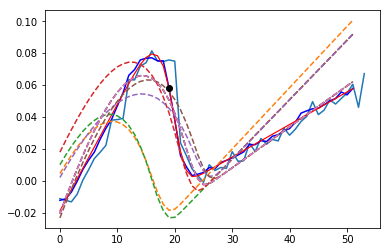

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 52
    # variables        = 7
    chi-square         = 8.2029e-04
    reduced chi-square = 1.8229e-05
    Akaike info crit   = -560.969224
    Bayesian info crit = -547.310518
[[Variables]]
    t0:     20.2634287 +/- 0.20659631 (1.02%) (init = 24.97836)
    sigma: -2.39565912 +/- 0.27466632 (11.47%) (init = -1.22226)
    alpha: -0.95472229 +/- 0.79555641 (83.33%) (init = -15.48294)
    a1:    -0.07991283 +/- 0.00864838 (10.82%) (init = -0.09262743)
    a2:     0.00461324 +/- 1.6402e-04 (3.56%) (init = 0.008031607)
    a5:     1.0931e-04 +/- 2.3731e-04 (217.09%) (init = -0.002545409)
    a6:    -8.34676484 +/- 1.61702240 (19.37%) (init = -5.832336)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.980
    C(a1, a6)       =  0.918
    C(a1, a5)       = -0.894
    C(sigma, alpha) = -0.692
    C(t0, alp

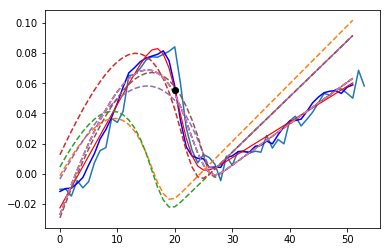

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00349667
    reduced chi-square = 4.3708e-05
    Akaike info crit   = -866.601228
    Bayesian info crit = -849.339872
[[Variables]]
    t0:     49.4868066 +/- 0.22077455 (0.45%) (init = 49.67557)
    sigma: -0.88309278 +/- 0.22944226 (25.98%) (init = -0.8460567)
    alpha: -4.67823893 +/- 0.37841296 (8.09%) (init = -5.235406)
    a1:    -0.16305132 +/- 0.03279474 (20.11%) (init = -0.1561102)
    a2:     0.00106173 +/- 8.6707e-05 (8.17%) (init = 0.001179183)
    a5:    -2.7911e-04 +/- 1.7875e-04 (64.04%) (init = -0.000377716)
    a6:    -157.254214 +/- 25.6859273 (16.33%) (init = -134.4613)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.983
    C(a5, a6)       = -0.935
    C(a1, a6)       =  0.857
    C(t0, alpha)    = -0.843
    C(t0, sigm

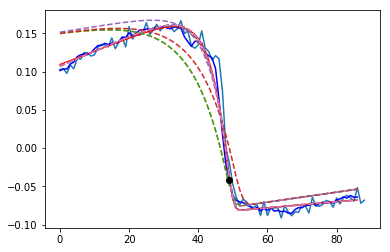

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00350467
    reduced chi-square = 4.3808e-05
    Akaike info crit   = -866.402259
    Bayesian info crit = -849.140902
[[Variables]]
    t0:     50.1155824 +/- 0.34043425 (0.68%) (init = 50.01484)
    sigma: -0.98016082 +/- 0.30362390 (30.98%) (init = -0.9258428)
    alpha: -3.88802847 +/- 0.49462334 (12.72%) (init = -3.774889)
    a1:     25.4101262 +/- 1576.23712 (6203.18%) (init = 21.7247)
    a2:     3.5570e-04 +/- 8.1732e-05 (22.98%) (init = 0.000303905)
    a5:     3.5839e-04 +/- 1.8167e-04 (50.69%) (init = 0.0003065479)
    a6:     71402.9559 +/- 4430387.95 (6204.77%) (init = 71435.39)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(a5, a6)       = -0.893
    C(a1, a5)       = -0.892
    C(t0, alpha)    = -0.882
    C(t0, si

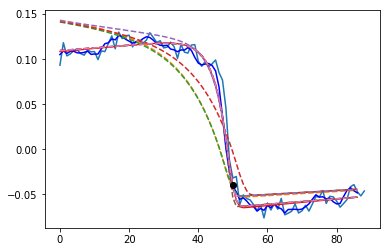

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00192187
    reduced chi-square = 3.7684e-05
    Akaike info crit   = -584.264182
    Bayesian info crit = -569.841081
[[Variables]]
    t0:     31.3569398 (init = 35.74769)
    sigma: -2.06469739 (init = -0.2183466)
    alpha: -0.15742675 (init = -11.29792)
    a1:    -0.40620381 (init = -0.1068939)
    a2:     0.00271487 (init = 0.004405637)
    a5:     0.00192781 (init = 0.0003179159)
    a6:    -159.712033 (init = -29.26562)



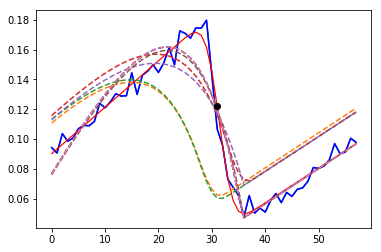

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 43
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00305398
    reduced chi-square = 5.9882e-05
    Akaike info crit   = -557.401594
    Bayesian info crit = -542.978493
[[Variables]]
    t0:     31.4647205 +/- 0.19140284 (0.61%) (init = 35.88772)
    sigma: -1.73591694 +/- 0.24155704 (13.92%) (init = -0.8573194)
    alpha: -0.27171055 +/- 147928.161 (54443290.03%) (init = -11.90844)
    a1:     0.07883086 +/- 0.02054061 (26.06%) (init = 0.07540374)
    a2:     0.00138597 +/- 1.7045e-04 (12.30%) (init = 0.003013685)
    a5:    -8.7293e-04 +/- 3.9311e-04 (45.03%) (init = -0.002262455)
    a6:    -26.5247210 +/- 8.97721641 (33.84%) (init = -10.56125)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.983
    C(a1, a5)    = -0.967
    C(a1, a6)    =  0.922
    C(a1, a2)    = -0.716
    C(t0, a6)    =

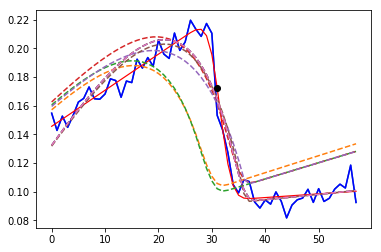

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 113
    # data points      = 52
    # variables        = 7
    chi-square         = 2.5554e-04
    reduced chi-square = 5.6786e-06
    Akaike info crit   = -621.616176
    Bayesian info crit = -607.957470
[[Variables]]
    t0:     21.8060534 +/- 0.74502141 (3.42%) (init = 23.75225)
    sigma: -1.16198208 +/- 0.40552409 (34.90%) (init = -0.8371817)
    alpha: -2.51184809 +/- 0.93666035 (37.29%) (init = -13.142)
    a1:    -0.14339816 +/- 0.03817329 (26.62%) (init = -0.06825263)
    a2:     0.00169881 +/- 1.2981e-04 (7.64%) (init = 0.003438316)
    a5:     9.0730e-04 +/- 1.5729e-04 (17.34%) (init = -0.0007754917)
    a6:    -74.9075514 +/- 27.1991380 (36.31%) (init = -15.95977)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.992
    C(a1, a6)       =  0.987
    C(t0, alpha)    = -0.969
    C(a5, a6)       = -0.961
    C(t0, si

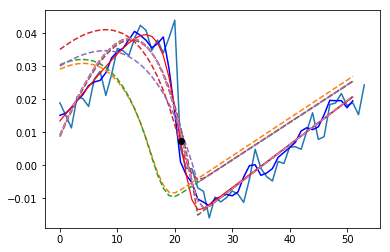

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 52
    # variables        = 7
    chi-square         = 5.4166e-04
    reduced chi-square = 1.2037e-05
    Akaike info crit   = -582.550193
    Bayesian info crit = -568.891487
[[Variables]]
    t0:     20.6776477 (init = 25.09982)
    sigma: -1.86514432 (init = -1.039325)
    alpha: -0.10088766 (init = -15.2364)
    a1:    -0.08162957 (init = -0.07588198)
    a2:     0.00308933 (init = 0.005836249)
    a5:     6.3941e-04 (init = -0.001593398)
    a6:    -18.6726904 (init = -8.505433)



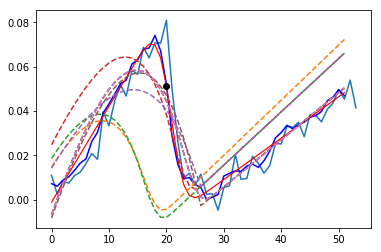

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 35
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00451752
    reduced chi-square = 5.6469e-05
    Akaike info crit   = -844.315966
    Bayesian info crit = -827.054609
[[Variables]]
    t0:     47.3683559 (init = 50.48062)
    sigma: -1.71054632 (init = -0.8457775)
    alpha: -0.18840701 (init = -5.288661)
    a1:    -0.14407132 (init = -0.163999)
    a2:     0.00214972 (init = 0.003293465)
    a5:    -0.00118731 (init = -0.001816288)
    a6:    -48.2418599 (init = -31.28788)



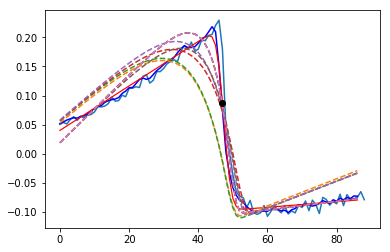

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 90
    # data points      = 87
    # variables        = 7
    chi-square         = 9.9072e-04
    reduced chi-square = 1.2384e-05
    Akaike info crit   = -976.319490
    Bayesian info crit = -959.058133
[[Variables]]
    t0:     47.8345332 +/- 0.09292098 (0.19%) (init = 49.84256)
    sigma: -2.05462358 +/- 0.12085253 (5.88%) (init = -1.064065)
    alpha: -0.80275422 +/- 0.25782670 (32.12%) (init = -2.802152)
    a1:     311.602699 +/- 15547.9215 (4989.66%) (init = 476.7505)
    a2:     5.8094e-04 +/- 3.6177e-05 (6.23%) (init = 0.000888844)
    a5:     5.8130e-04 +/- 4.1372e-05 (7.12%) (init = 0.0008892386)
    a6:     536381.955 +/- 26765266.9 (4989.96%) (init = 536387.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(a2, a5)       =  0.901
    C(t0, alpha)    = -0.815
    C(sigma, alpha) = -0.680
    C(t0, sigma

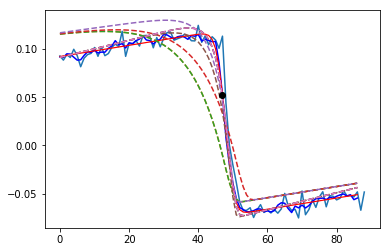

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 54
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00308278
    reduced chi-square = 6.0447e-05
    Akaike info crit   = -556.857230
    Bayesian info crit = -542.434129
[[Variables]]
    t0:     31.4704945 (init = 35.91363)
    sigma: -2.17917445 (init = -0.9802795)
    alpha: -0.23444776 (init = -11.44967)
    a1:    -0.69040963 (init = -0.1126578)
    a2:     0.00263165 (init = 0.004216311)
    a5:     0.00214856 (init = 0.0004424973)
    a6:    -271.744177 (init = -31.97607)



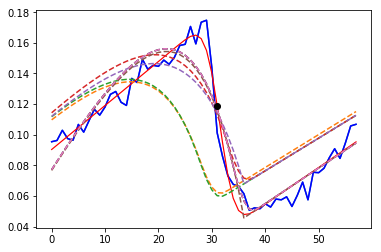

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00295210
    reduced chi-square = 5.7884e-05
    Akaike info crit   = -559.369576
    Bayesian info crit = -544.946475
[[Variables]]
    t0:     32.5644409 +/- 1.36190989 (4.18%) (init = 35.57176)
    sigma: -0.99992034 +/- 0.75697239 (75.70%) (init = -0.5053654)
    alpha: -1.70518413 +/- 1.20332177 (70.57%) (init = -11.63465)
    a1:     0.10180396 +/- 0.02043841 (20.08%) (init = 0.09582278)
    a2:     0.00103729 +/- 1.6247e-04 (15.66%) (init = 0.002556854)
    a5:    -8.7625e-04 +/- 3.8290e-04 (43.70%) (init = -0.002160807)
    a6:    -34.9148022 +/- 11.8065747 (33.82%) (init = -13.5691)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.982
    C(a5, a6)       = -0.978
    C(a1, a5)       = -0.959
    C(t0, sigma)    =  0.953
    C(sigma,

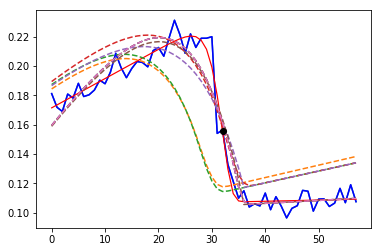

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 77
    # data points      = 52
    # variables        = 7
    chi-square         = 4.4452e-04
    reduced chi-square = 9.8782e-06
    Akaike info crit   = -592.827847
    Bayesian info crit = -579.169141
[[Variables]]
    t0:     21.1332677 +/- 0.57124236 (2.70%) (init = 25.24606)
    sigma: -0.71559960 +/- 0.36227059 (50.62%) (init = -0.05132888)
    alpha: -1.61568406 +/- 0.55217863 (34.18%) (init = -14.34138)
    a1:     410.772620 +/-        nan (nan%) (init = 427.7039)
    a2:     0.00109958 +/- 6.6126e-05 (6.01%) (init = 0.001144824)
    a5:     0.00109974 +/- 6.6039e-05 (6.00%) (init = 0.00114507)
    a6:     373583.722 +/-        nan (nan%) (init = 373594.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, a5)       =  1.010
    C(t0, alpha)    = -0.962
    C(t0, sigma)    =  0.864
    C(sigma, alpha) = -0.807
    C(alpha, a5)    = 

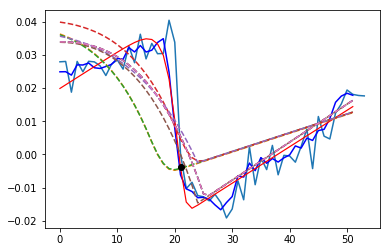

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 52
    # variables        = 7
    chi-square         = 7.3478e-04
    reduced chi-square = 1.6328e-05
    Akaike info crit   = -566.693392
    Bayesian info crit = -553.034686
[[Variables]]
    t0:     20.6884230 +/- 0.16351296 (0.79%) (init = 25.44377)
    sigma: -1.94170877 +/- 0.17821800 (9.18%) (init = -1.239243)
    alpha: -0.31946008 +/- 34668.2371 (10852134.47%) (init = -15.66321)
    a1:    -0.05127315 +/- 0.00769341 (15.00%) (init = -0.06376414)
    a2:     0.00346841 +/- 1.6271e-04 (4.69%) (init = 0.006418027)
    a5:     3.2840e-05 +/- 2.1318e-04 (649.16%) (init = -0.00217862)
    a6:    -9.31879702 +/- 1.96537372 (21.09%) (init = -6.11134)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.979
    C(a1, a6)    =  0.893
    C(a1, a5)    = -0.871
    C(alpha, a2) = -0.725
    C(t0, a5)    =  0

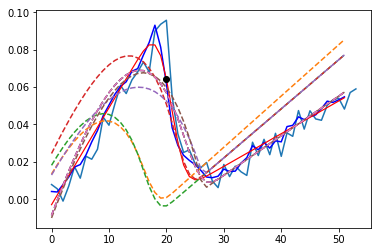

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 35
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00587433
    reduced chi-square = 7.3429e-05
    Akaike info crit   = -821.467143
    Bayesian info crit = -804.205786
[[Variables]]
    t0:     47.3555971 (init = 50.37516)
    sigma: -1.70107426 (init = -0.8617787)
    alpha: -0.19420744 (init = -5.10209)
    a1:    -0.13328439 (init = -0.1534319)
    a2:     0.00224603 (init = 0.003399435)
    a5:    -0.00142031 (init = -0.0020823)
    a6:    -40.8505352 (init = -26.98118)



/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: overflow encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


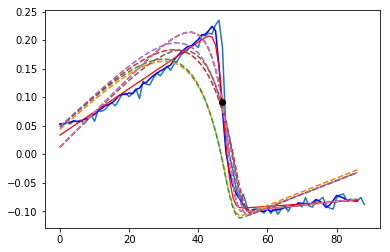

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 79
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00318637
    reduced chi-square = 3.9830e-05
    Akaike info crit   = -874.686038
    Bayesian info crit = -857.424681
[[Variables]]
    t0:     49.2654165 +/- 0.67407515 (1.37%) (init = 49.5431)
    sigma: -1.07889889 +/- 0.39112751 (36.25%) (init = -1.050025)
    alpha: -1.96997850 +/- 0.60325614 (30.62%) (init = -2.355894)
    a1:     18.8067663 +/- 1418.41117 (7542.03%) (init = 26.92817)
    a2:     1.9649e-04 +/- 6.8425e-05 (34.82%) (init = 0.0002814424)
    a5:     1.9835e-04 +/- 1.6550e-04 (83.44%) (init = 0.0002833458)
    a6:     95629.4145 +/- 7223860.76 (7554.02%) (init = 95630.47)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(t0, alpha)    = -0.976
    C(t0, sigma)    =  0.933
    C(a5, a6)       = -0.913
    C(a1, a5

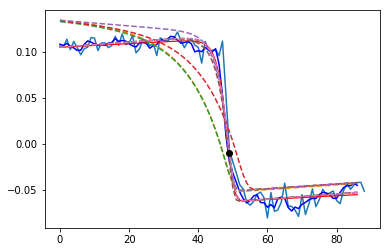

In [25]:
est_sigma=-1
est_alpha=-10

results_ref_304_220 = [dict() for x in range(len(ref_304))]
results_ref_316_220 = [dict() for x in range(len(ref_304))]

results_ref_304_200 = [dict() for x in range(len(ref_304))]
results_ref_316_200 = [dict() for x in range(len(ref_304))]

results_ref_304_111 = [dict() for x in range(len(ref_304))]
results_ref_316_111 = [dict() for x in range(len(ref_304))]

for i in range(0, len(ref_304)):
    results_ref_304_200[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref304_spectrum_binned[i]), myrange_200, peak_position_200, est_sigma, est_alpha, False, False)
    results_ref_316_200[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref316_spectrum_binned[i]), myrange_200, peak_position_200, est_sigma,  est_alpha, False, False)
    results_ref_304_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref304_spectrum_binned[i]), myrange_220, peak_position_220, est_sigma, est_alpha, False, True)
    results_ref_316_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref316_spectrum_binned[i]), myrange_220, peak_position_220, est_sigma,  est_alpha, False, True)
    results_ref_304_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref304_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma, est_alpha, False, True)
    results_ref_316_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref316_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma,  est_alpha, False, True)  
#     results_ref_304_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref304_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma, est_alpha, False, True)
#     results_ref_316_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(ref316_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma,  est_alpha, False, True)    

0
1
2
3
4
5
6
7
8
9
10


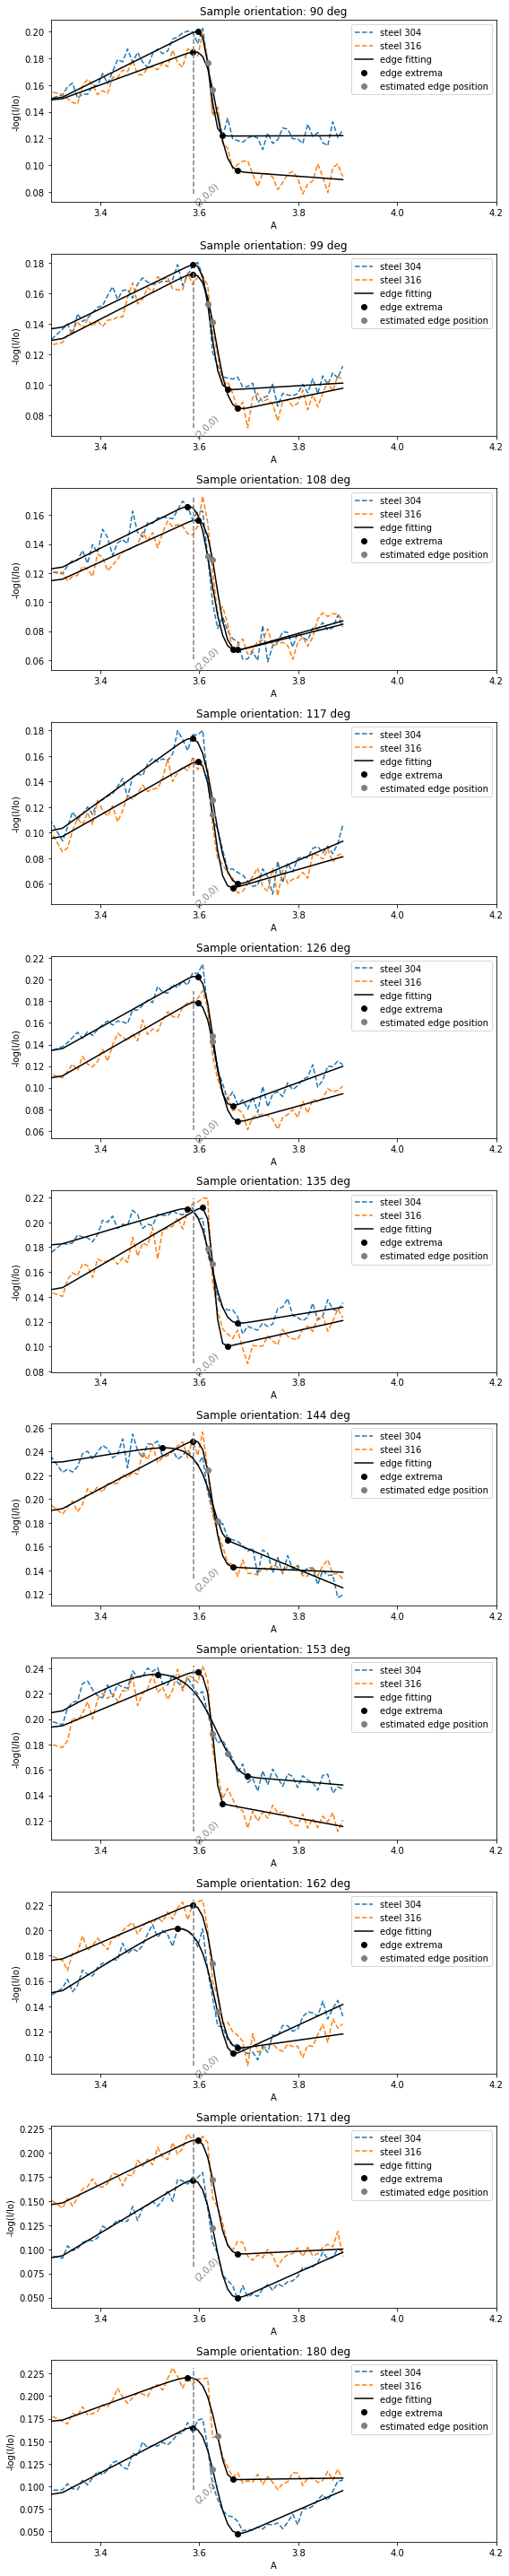

In [11]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_200=[]
peak_height_316_200=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_ref_304_200)):
    print(i)


    results_304 = results_ref_304_200[i]['final_result']
    fitted_data_304=results_ref_304_200[i]['fitted_data']
    pos_extrema_304 = results_ref_304_200[i]['pos_extrema']  
    pos_peak_304 = results_ref_304_200[i]['t0']
    peak_height_304_200.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_ref_316_200[i]['final_result']
    fitted_data_316=results_ref_316_200[i]['fitted_data']
    pos_extrema_316 = results_ref_316_200[i]['pos_extrema']  
    pos_peak_316 = results_ref_316_200[i]['t0']
#     print(pos_extrema_316)
    peak_height_316_200.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])


    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],-1*np.log(ref304_spectrum_binned[i][myrange_200[0]:myrange_200[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],-1*np.log(ref316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_200[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_200[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_200[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_200[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
    ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[1],2*dhkl_gammaFe[1]]), np.array([np.min(-1*np.log(ref316_spectrum_binned[i][myrange_200[0]:myrange_200[1]])), np.max(-1*np.log(ref316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[1]).astype(int))+','+str(k_gammaFe[1].astype(int))+','+str(l_gammaFe[1].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[1],np.min(-1*np.log(ref316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_200.eps', format='eps', dpi=400)
np.savetxt('peak_height_304_200.txt', peak_height_304_200)
np.savetxt('peak_height_316_200.txt', peak_height_316_200)

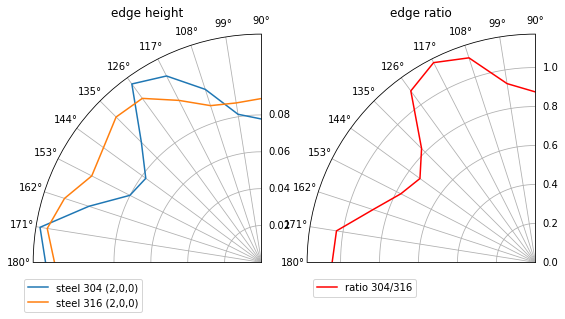

In [12]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_200[i]/peak_height_316_200[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')
ax.plot(theta, peak_height_304_200, label='steel 304 (2,0,0)')
ax.plot(theta, peak_height_316_200, label='steel 316 (2,0,0)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
plt.title('edge ratio')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

fig.savefig('polar_peakheight_200.eps', format='eps', dpi=400)

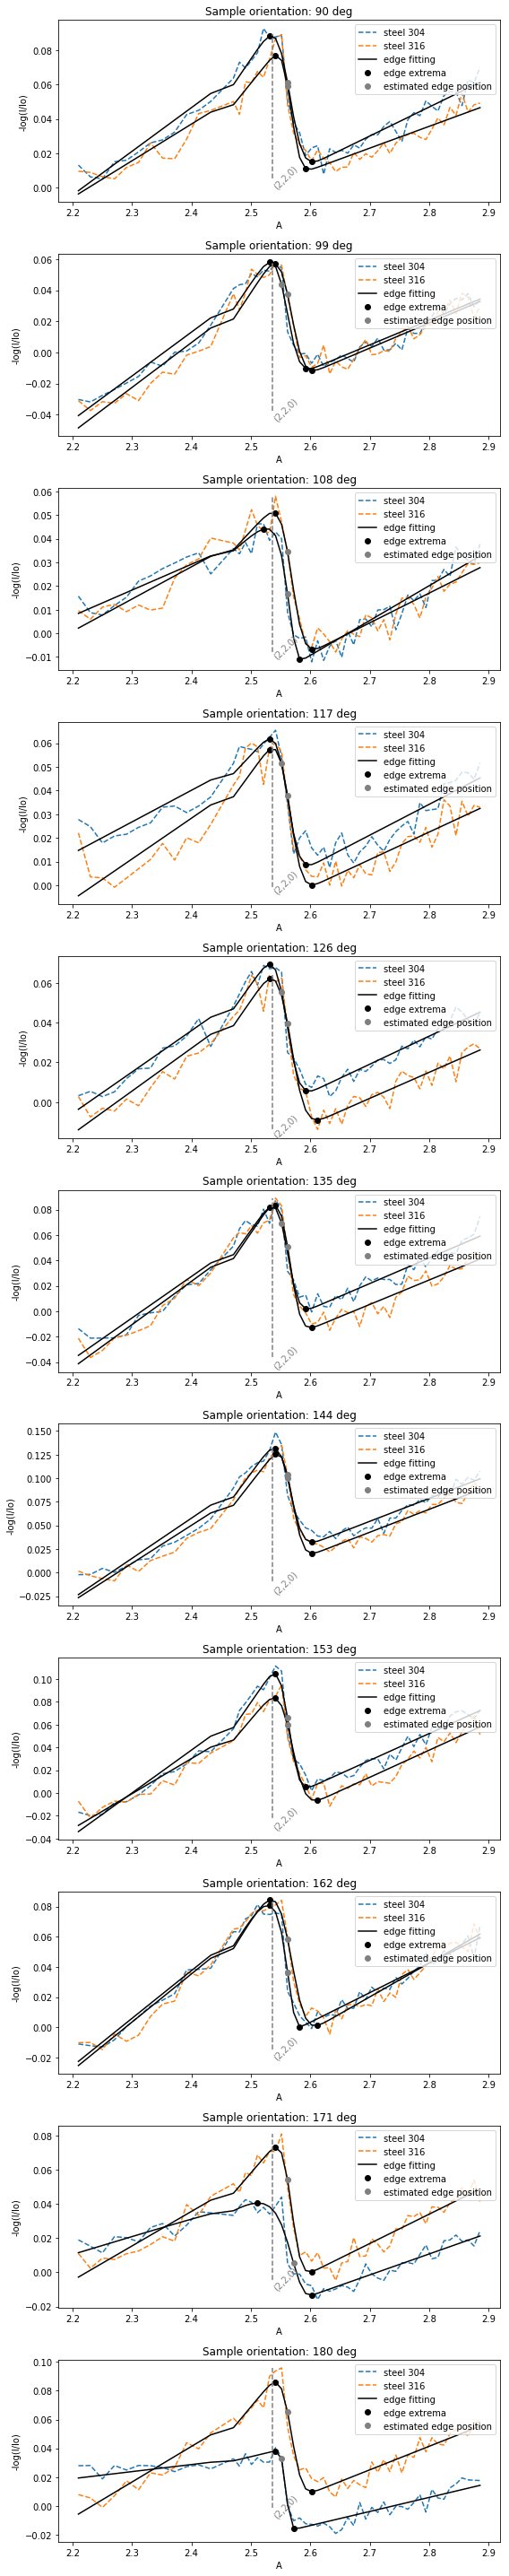

In [13]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_220=[]
peak_height_316_220=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_ref_304_220)):


    results_304 = results_ref_304_220[i]['final_result']
    fitted_data_304=results_ref_304_220[i]['fitted_data']
    pos_extrema_304 = results_ref_304_220[i]['pos_extrema']  
    pos_peak_304 = results_ref_304_220[i]['t0']
    peak_height_304_220.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_ref_316_220[i]['final_result']
    fitted_data_316=results_ref_316_220[i]['fitted_data']
    pos_extrema_316 = results_ref_316_220[i]['pos_extrema']  
    pos_peak_316 = results_ref_316_220[i]['t0']
    peak_height_316_220.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])

    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],-1*np.log(ref304_spectrum_binned[i][myrange_220[0]:myrange_220[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],-1*np.log(ref316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_220[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_220[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_220[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_220[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[2],2*dhkl_gammaFe[2]]), np.array([np.min(-1*np.log(ref316_spectrum_binned[i][myrange_220[0]:myrange_220[1]])), np.max(-1*np.log(ref316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[2]).astype(int))+','+str(k_gammaFe[2].astype(int))+','+str(l_gammaFe[2].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[2],np.min(-1*np.log(ref316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_220.eps', format='eps', dpi=400)

np.savetxt('peak_height_304_220.txt', peak_height_304_220)
np.savetxt('peak_height_316_220.txt', peak_height_316_220)

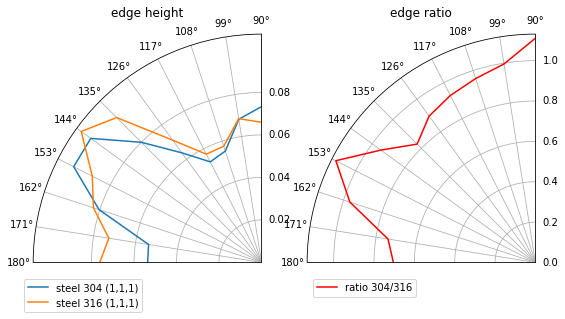

In [14]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_220[i]/peak_height_316_220[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')

ax.plot(theta, peak_height_304_220, label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_220, label='steel 316 (1,1,1)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')

fig.savefig('polar_peakheight_220.eps', format='eps', dpi=400)

[0, 52]
[0, 53]
[37, 52]
[35, 53]
[42, 53]
[40, 52]
[43, 52]
[44, 53]
[38, 52]
[44, 53]
[22, 52]
[38, 52]
[0, 52]
[0, 53]
[0, 51]
[0, 53]
[33, 52]
[31, 52]
[43, 52]
[41, 53]
[43, 52]
[37, 52]


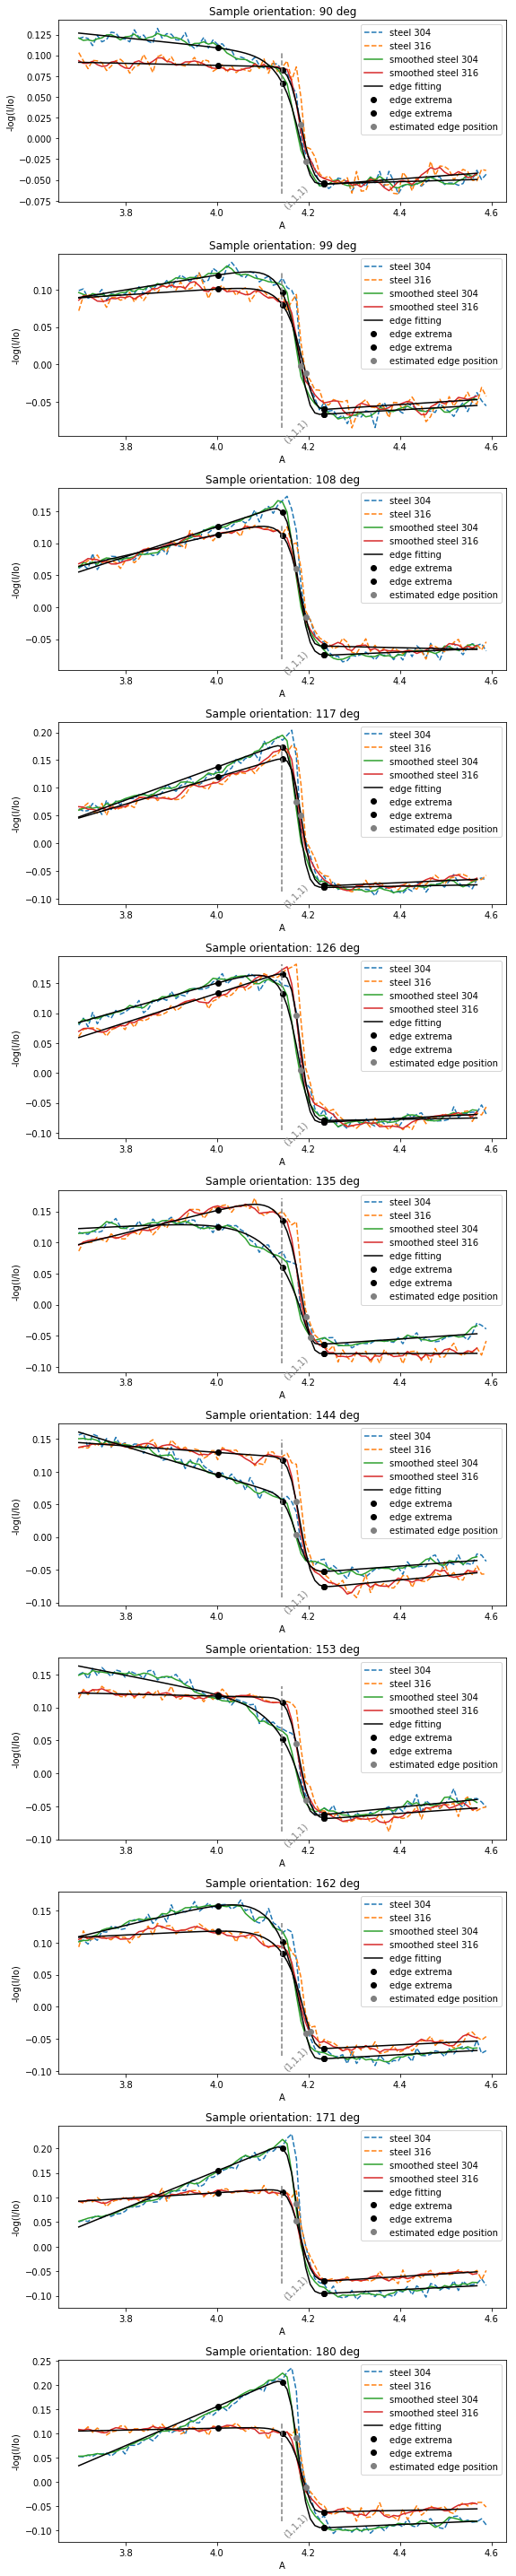

In [26]:
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_110=[]
peak_height_316_110=[]

peak_height_304_111=[]
peak_height_316_111=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')
defined_height_pos_110 = np.array([30,53])
defined_height_pos_111 = np.array([find_nearest(mylambda_binned,2*dhkl_gammaFe[0])-myrange_111[0],53])

for i in range(0,len(results_ref_304_111)):


    results_304 = results_ref_304_111[i]['final_result']
    fitted_data_304=results_ref_304_111[i]['fitted_data']
    pos_extrema_304 = results_ref_304_111[i]['pos_extrema'] 
    print(pos_extrema_304)
    pos_peak_304 = results_ref_304_111[i]['t0']
    
    defined_height_pos_110 = np.array([30,53])
    defined_height_pos_111 = np.array([find_nearest(mylambda_binned,2*dhkl_gammaFe[0])-myrange_111[0],53])

    results_316 = results_ref_316_111[i]['final_result']
    fitted_data_316=results_ref_316_111[i]['fitted_data']
    pos_extrema_316 = results_ref_316_111[i]['pos_extrema']  
    print(pos_extrema_316)
    pos_peak_316 = results_ref_316_111[i]['t0']

    if defined_height_pos_111[1]< pos_peak_304:
        defined_height_pos_111[1]=pos_peak_304
    elif defined_height_pos_111[1] < pos_peak_316:
        defined_height_pos_111[1] = pos_peak_316
        
    if defined_height_pos_110[1]< pos_peak_304:
        defined_height_pos_110[1]=pos_peak_304
    elif defined_height_pos_110[1] < pos_peak_316:
        defined_height_pos_110[1] = pos_peak_316
        
    peak_height_316_110.append(fitted_data_316[defined_height_pos_110[0]]-fitted_data_316[defined_height_pos_110[1]])
    peak_height_316_111.append(fitted_data_316[defined_height_pos_111[0]]-fitted_data_316[defined_height_pos_111[1]])
                

    peak_height_304_110.append( fitted_data_304[defined_height_pos_110[0]]-fitted_data_304[defined_height_pos_110[1]])
    peak_height_304_111.append( fitted_data_304[defined_height_pos_111[0]]-fitted_data_304[defined_height_pos_111[1]])
        
#     print(peak_height_304, peak_height_316)

    # start with one
#     plt.figure()
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]],-1*np.log(ref304_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]],-1*np.log(ref316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),'--', label='steel 316')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref304_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),3), label='smoothed steel 304')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(ref316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_111[0:2]],fitted_data_304[defined_height_pos_111[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_111[0:2]],fitted_data_316[defined_height_pos_111[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_110[0:2]],fitted_data_304[defined_height_pos_110[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_110[0:2]],fitted_data_316[defined_height_pos_110[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_111[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_111[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
#     ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[0],2*dhkl_gammaFe[0]]), np.array([np.min(-1*np.log(ref316_spectrum_binned[i][myrange_111[0]:myrange_111[1]])), np.max(-1*np.log(ref316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[0]).astype(int))+','+str(k_gammaFe[0].astype(int))+','+str(l_gammaFe[0].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[0],np.min(-1*np.log(ref316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_111.eps', format='eps', dpi=400)

np.savetxt('peak_height_304_110.txt', peak_height_304_110)
np.savetxt('peak_height_316_110.txt', peak_height_316_110)

np.savetxt('peak_height_304_111.txt', peak_height_304_111)
np.savetxt('peak_height_316_111.txt', peak_height_316_111)

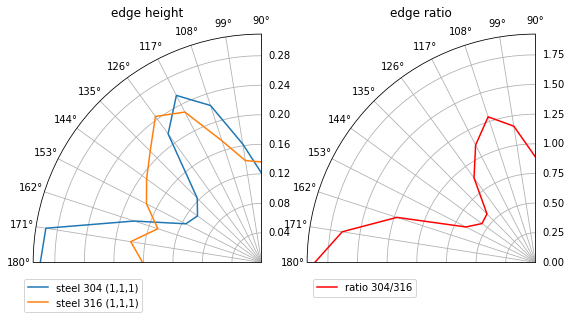

In [32]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_111[i]/peak_height_316_111[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')

ax.plot(theta, peak_height_304_111, label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_111, label='steel 316 (1,1,1)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.04,0.08,0.12,0.16,0.2,0.24,0.28])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')

fig.savefig('polar_peakheight_111.eps', format='eps', dpi=400)


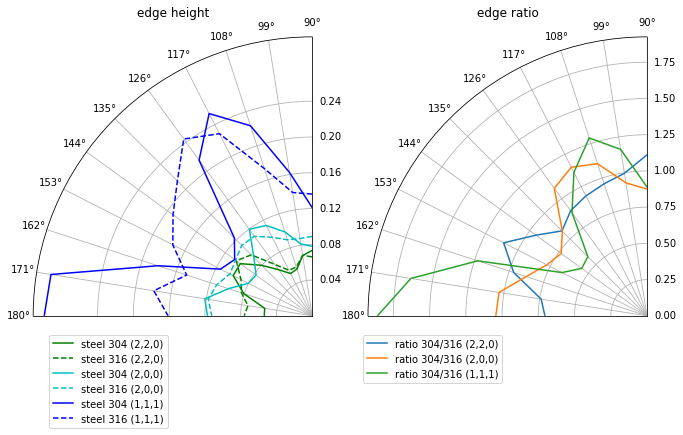

In [29]:

cmap = matplotlib.cm.viridis
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio_220=[]
ratio_200=[]
ratio_111=[]
ratio_110=[]

for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio_220.append(peak_height_304_220[i]/peak_height_316_220[i])
    ratio_200.append(peak_height_304_200[i]/peak_height_316_200[i])
    ratio_111.append(peak_height_304_111[i]/peak_height_316_111[i])
    ratio_110.append(peak_height_304_110[i]/peak_height_316_110[i])
    
fig = plt.figure( figsize=[11,8])
ax=fig.add_subplot(121,polar='True')
# ax=fig.add_subplot(121)
ax.plot(theta, peak_height_304_220, 'g', label='steel 304 (2,2,0)')
ax.plot(theta, peak_height_316_220, 'g--',label='steel 316 (2,2,0)')
ax.plot(theta, peak_height_304_200, 'c', label='steel 304 (2,0,0)')
ax.plot(theta, peak_height_316_200, '--c', label='steel 316 (2,0,0)')
ax.plot(theta, peak_height_304_111,'b' ,label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_111, 'b--',label='steel 316 (1,1,1)')
# ax.plot(theta, peak_height_304_110,'r', label='steel 304 (1,1,0)')
# ax.plot(theta, peak_height_316_110, 'r--', label='steel 316 (1,1,0)')
# ax.set_yticks([0.02,0.04,0.06,0.08, 0.1, 0.12, 0.14, 0.16])
ax.set_yticks([0.04,0.08,0.12,0.16, 0.20, 0.24])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
# ax=fig.add_subplot(122)
ax.plot(theta, ratio_220, label='ratio 304/316 (2,2,0)')
ax.plot(theta, ratio_200, label='ratio 304/316 (2,0,0)')
ax.plot(theta, ratio_111, label='ratio 304/316 (1,1,1)')
# ax.plot(theta, ratio_110, label='ratio 304/316 (1,1,0)')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')
fig.savefig('Edge_plotting_all_ref.eps', format='eps', dpi=400)